# Entregable 1 - Data Engineering & Preprocessing

**Proyecto:** Limpieza y Preprocesado de Datos para Predicción de Precios  
**Dataset:** bmw_pricing_v3.csv  
**Objetivo:** Preparar datos para modelo de Machine Learning  
**Integrante:** Gabriela Alberico, Jorge Silva, Robert Tunzi, Matias Lannes, Alexis Labrador  
**Fecha:** Diciembre 2025

---

## 1. IMPORTS Y CONFIGURACIÓN

### 1.1 Configuración para Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.2 Importar librerías

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

print("Librerías importadas correctamente!")

Librerías importadas correctamente!


### 1.3 Declaración de variables globales

In [3]:
pd.set_option('display.width', 1000)

BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/"

### 1.4 Librerías locales

In [4]:
# Lista de columnas con valores nulos
def obtener_columnas_con_nulos(df: pd.DataFrame) -> pd.DataFrame:
    """
        Obtiene las columnas con NULLS de un dataset

        Args:
            df: Dataset a analizar

        Return:
            Dataframe con las columnas con NULLS y su porcentaje
    """
    null_counts = df.isnull().sum()
    null_porcentajes = (df.isnull().sum() / len(df)) * 100

    null_info = pd.DataFrame({
        'null_count': null_counts,
        'null_porcentaje': null_porcentajes
    })

    return null_info.sort_values(by='null_count', ascending=False)


def separar_column_tipo_fecha(df: pd.DataFrame, list_columns: list = []) -> pd.DataFrame:
    """
        Separa el año, mes y día en columnas distintas según list_columns

        Args:
            df: Dataset a analizar
            list_columns: Lista de columnas a analizar

        Return:
            Dataframe con las columnas separadas
    """
    for column in list_columns:
        df[column + '_Year'] = df[column].dt.year
        df[column + '_Month'] = df[column].dt.month
        df[column + '_Weekday'] = df[column].dt.weekday

    return df


def suprimir_columna(df: pd.DataFrame, list_columns: list, mostrar_log: bool = False) -> None:
    """
        Elimina columnas según list_columns

        Args:
            df: Dataset a analizar
            list_columns: Lista de columnas a eliminar
            mostrar_log: Muestra el log de columnas eliminadas

        Return:
            Dataframe con las columnas eliminadas
    """
    if mostrar_log:
        print(f"Lista de columnas antes de borrar: {df.columns.tolist()}")

    for col in list_columns:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
            print(f"Columna '{col}' suprimida")
        else:
            print(f"Columna '{col}' no encontrada en el DataFrame")

    if mostrar_log:
        print(f"Lista de columnas luego de borrar: {df.columns.tolist()}")


def aplicar_one_hot_encoding(df: pd.DataFrame, list_columns: list = []) -> pd.DataFrame:
    """
        Aplica One Hot Encoding a las columnas list_columns

        Args:
            df: Dataset a analizar
            list_columns: Lista de columnas a aplicar One Hot Encoding

        Return:
            Dataframe con las columnas One Hot Encoding aplicadas
    """
    # Transforma las variables categóricas mediante OHE usando get_dummies
    df = pd.get_dummies(data=df, columns=list_columns, dtype=int)
    display(df.info())
    print("\n")
    return df


# Colocar la moda de la columna segun modelo
def actualizar_columna_null_con_moda(df: pd.DataFrame, modelo_code: str, column_name: str) -> pd.DataFrame:
    """
        Rellena los valores NaN de la columna column_name de un dataset
        según el agrupado de la columna "modelo"

        Args:
            df: Dataset a analizar
            modelo_code: Código del modelo
            column_name: Columna a analizar

        Return:
            Dataframe con la columna rellenada
    """
    # Filtrar el modelo
    filtro = df["modelo"] == str(modelo_code)

    # Calcular la moda del parámetro columna_name
    mode_result = df.loc[filtro, column_name].mode(dropna=False)

    if mode_result.empty:
        print(f"Advertencia: No se encontró una moda válida para columna '{column_name}' del modelo {modelo_code}. Los nulos no serán rellenados para este modelo.")
    else:
        moda_modelo = mode_result.iloc[0]
        # Solo rellena si la moda no es NaN
        if pd.isna(moda_modelo):
            print(f"Advertencia: La moda para la columna '{column_name}' del modelo {modelo_code} es NaN. Los nulos no serán rellenados para este modelo.")
        else:
            print(f"La moda para la columna '{column_name}', modelo '{modelo_code}' es {moda_modelo}")
            df.loc[filtro, column_name] = df.loc[filtro, column_name].fillna(moda_modelo)

    return df


def tratamiento_columna_color(df: pd.DataFrame) -> pd.DataFrame:
    """
        Tratamiento de valores nulos para la columna "color", agregar moda
        de la columna segun modelo

        Args:
            df: DataFrame a procesar
        Returns:
            DataFrame procesado
    """
    lista_modelos_con_color_nulo = df.loc[df["color"].isnull()]["modelo"].unique()

    for modelo_code in lista_modelos_con_color_nulo:
        df = actualizar_columna_null_con_moda(df, modelo_code, "color")

    return df


def tratamiento_columna_tipo_coche(df: pd.DataFrame) -> pd.DataFrame:
    """
        Actualizar la columna tipo_coche con valor nulo como "no_indicado"

        Args:
            df: DataFrame a procesar

        Returns:
            DataFrame procesado
    """
    lista_modelos_con_color_nulo = df.loc[df["tipo_coche"].isnull()]["modelo"].unique()
    for modelo_code in lista_modelos_con_color_nulo:
        df = actualizar_columna_null_con_moda(df, modelo_code, "tipo_coche")

    # Aplica valor
    df.fillna({ "tipo_coche": "no_indicado"}, inplace=True)
    return df


def describe_columna_value_accounts(df: pd.DataFrame, column_name: str):
    """
        Obtiene el conteo absoluto (incluyendo NaN) y porcentaje con respecto
        al total de la columna column_name

        Args:
            df: DataFrame a procesar
            column_name: Columna a procesar

        Returns:
            DataFrame con el conteo absoluto y porcentaje de la columna column_name
    """
    counts = 0
    percentages = 0

    if column_name in df.columns:
        # Conteos absolutos
        counts = df[[column_name]].value_counts(dropna=False)

        # Calcula porcentajes
        percentages = (counts / counts.sum() * 100).round(2)

        # Combinar en un DataFrame
        result = pd.DataFrame({
            "count": counts,
            "percentage": percentages
        })

    else:
        result = f"La columna '{column_name}' no existe"

    return result


def create_boolean_column_to_numerica(df: pd.DataFrame, column_name_bool: str, column_name_suffix: str = "_number" ) -> pd.DataFrame:
    """
        Crear nueva columna numérica a partir de una columna boolean
        y la rellena con los siguientes parámetros según el valor:
            1 si es True
            0 si es False
            -1 si es NaN

        Args:
            df: DataFrame a procesar
            column_name_bool: Columna a procesar
            column_name_sufix: Suffix de la nueva columna

        Returns:
            DataFrame procesado
    """
    columna = df.get(column_name_bool)

    if columna is not None:
        df[column_name_bool + column_name_suffix] = columna.map({True: 1, False: 0}).fillna(-1)
        print(f"Columna '{column_name_bool}' actualizada a '{column_name_bool + column_name_suffix}'\n")
    else:
        print(f"La columna '{column_name_bool}' no existe en el DataFrame.\n")

    return df


def reemplazar_espacios_por_guion(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
        Reemplaza los espacios en blanco por guiones en la columna column_name

        Args:
            df: DataFrame a procesar
            column_name: Columna a procesar

        Returns:
            DataFrame procesado
    """
    df[column_name] = (
        df[column_name]
        .str.strip()                            # Elimina espacios al inicio/fin
        .str.replace(" ", "-", regex=False)     # Reemplaza espacios internos
    )

    return df


def guardar_archivo(df: pd.DataFrame, name_file: str, limit: int = 0, tipo: str = "pickle") -> None:
    """
        Almacena el dataset en un fichero pickle o excel

        Args:
            df: DataFrame para almacenar
            name_file: Nombre del archivo
            limit: Limite de filas a almacenar
            tipo: Tipo de archivo a almacenar (pickle o excel)
    """
    if limit > 0:
        if tipo == "pickle":
            pd.to_pickle(df.head(limit), name_file)
        else:
            df.head(limit).to_excel(name_file, sheet_name="DatosLimpios", index=False)
    else:
        if tipo == "pickle":
            pd.to_pickle(df, name_file)
        else:
            df.to_excel(name_file, sheet_name="DatosLimpios", index=False)

    print(f"Fichero tipo '{tipo}' guardado en: {name_file}")


def resumen_categorico(df: pd.DataFrame, column_name: str, target_column: str, mostrar_grafico: bool = True) -> pd.DataFrame:
    """
        Genera tabla de frecuencias absolutas y relativas para columnas categóricas
        y opcionalmente muestra un violinplot contra una variable numérica (target)

    Args:
        df: DataFrame a analizar
        column_name: Nombre de la columna categórica
        target: Nombre de la columna numérica para comparar en el violinplot
        mostrar_grafico (Opcional): True para mostrar el gráfico (default = True)

    Return:
        Dataset con frecuencias absolutas y relativas
    """
    # Calcular frecuencias
    freq_abs = df[column_name].value_counts(dropna=False)
    freq_rel = df[column_name].value_counts(normalize=True, dropna=False) * 100

    # Crear DataFrame resumen ordenado
    df_resumen = pd.DataFrame({
        "Frecuencia Absoluta": freq_abs,
        "Frecuencia Relativa (%)": freq_rel.round(2)
    }).sort_values(by="Frecuencia Absoluta", ascending=False)

    # Mostrar gráfico si se solicita
    if mostrar_grafico:
        plt.figure(figsize=(12, 6))
        sns.violinplot(x=column_name, y=target_column, data=df, palette="pastel", cut=0)
        plt.title(f"Distribución de {target_column} según {column_name}", fontsize=14, fontweight="bold")
        plt.xticks(rotation=45)
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.show()

    return df_resumen


def graficos_numericos(df: pd.DataFrame, column_name: str) -> None:
    """
        Genera histograma con KDE y boxplot para columnas numéricas

        Args:
            df: DataFrame a analizar
            column_name: Nombre de la columna numérica
    """
    mean_val = df[column_name].mean()
    median_val = df[column_name].median()

    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    # Histograma
    sns.histplot(
        df[column_name].dropna(),
        kde=True,
        bins=30,
        color="skyblue",
        edgecolor="black",
        alpha=0.7,
        ax=axes[0]
    )
    axes[0].axvline(mean_val, color="red", linestyle="--", label=f"Media: {mean_val:.2f}")
    axes[0].axvline(median_val, color="green", linestyle="-.", label=f"Mediana: {median_val:.2f}")
    axes[0].set_title(f"Histograma de {column_name}")
    axes[0].legend()
    axes[0].grid(axis="y", linestyle="--", alpha=0.6)
    print("\n")

    # Boxplot
    sns.boxplot(
        x=df[column_name].dropna(),
        color="lightgreen",
        ax=axes[1]
    )
    axes[1].set_title(f"Boxplot de {column_name}")

    plt.suptitle(f"Distribución de {column_name}", fontsize=14, fontweight="bold")
    plt.show()


def analizar_target_con_columna_numerica(df: pd.DataFrame, column_name: str, target_column: str = "precio") -> None:
    """
        Genera scatterplot para columna numérica contra el target

        Args:
            df: DataFrame a analizar
            column_name: Nombre de la columna numérica
            target_column: Nombre de la columna target (default = "precio")
    """
    if df[column_name].dtype.kind in ["i", "f"] and column_name != target_column:
        plt.figure(figsize=(14, 5))         # Tamaño de la figura
        sns.scatterplot(
            x=column_name,
            y=target_column,
            data=df,
            hue=target_column,              # Color según precio
            size=target_column,             # Tamaño según precio
            alpha=0.7,                      # Transparencia para mejor visualización
            edgecolor="k"                   # Borde negro en los puntos
        )

        # Títulos y etiquetas
        plt.title(f"Relación entre {column_name} y {target_column}", fontsize=16, fontweight="bold")
        plt.xlabel(column_name, fontsize=14)
        plt.ylabel(f"{target_column} (€)", fontsize=14)

        # Ajustar leyenda y diseño
        plt.legend(title=target_column, loc="upper right")
        plt.tight_layout()


def analisis_exploratorio_basico(df: pd.DataFrame) -> None:
    """
        Análisis exploratorio básico de un DataFrame

        Args:
            df: DataFrame a analizar
    """
    for idx in df:
        if df[idx].dtype.kind == "O":
            print(f"{idx}\n")
            display(df[idx].value_counts(dropna=False))

        elif df[idx].dtype.kind in ["f", "i"]:
            print(df.hist(idx))


def analisis_exploratorio(df: pd.DataFrame, columns: list = None, target_column: str = "", display_categoricas: bool = False, display_numericas: bool = False) -> None:
    """
        Análisis exploratorio de un DataFrame

        Args:
            df: DataFrame a analizar
            columns: Lista de columnas a analizar (default = None)
            target_column: Nombre de la columna target (default = "")
            display_categoricas: Mostrar análisis de columnas categóricas (default = False)
            display_numericas: Mostrar análisis de columnas numéricas (default = False)
    """
    print("Información general del DataFrame\n")
    print("-" * 50, "\n")
    print(f"Shape: {df.shape}\n")
    print(f"Tipos de datos:\n{df.dtypes}\n")
    print(f"Valores nulos por columna:\n{df.isnull().sum()}\n")
    print("-" * 50)

    # Selección de columnas
    if columns is None:
        columns = df.columns

    for col in columns:
        print(f"\nColumna: {col}\n" + "-" * 30)

        # Categóricas
        if (df[col].dtype == "object" or str(df[col].dtype) == "category") and display_categoricas == True:
            print("Tipo: Categórica")
            print(f"Nº de categorías únicas: {df[col].nunique()}")
            print(f"Moda: {df[col].mode()[0] if not df[col].mode().empty else 'N/A'}")

            df_resumen = resumen_categorico(df, col, target_column)
            print("\n")
            display(df_resumen)
            print("\n")

            # Gráfico de barras
            plt.figure(figsize=(6, 4))
            sns.countplot(x=col, data=df, order=df_resumen.index)
            plt.title(f"Distribución de {col}")
            plt.xticks(rotation=45)
            plt.show()

        # Numéricas
        elif pd.api.types.is_numeric_dtype(df[col]) and display_numericas == True:
            print("Tipo: Numérica\n")
            print(f"Estadísticas descriptivas:\n{df[col].describe()}\n")

            graficos_numericos(df, col)
            analizar_target_con_columna_numerica(df, col, target_column)

        else:
            print("Tipo desconocido")

        print("\n")


def tratamiento_columna_marca(df: pd.DataFrame) -> None:
    """
        Verificando si los modelos de la "marca" = NULL tienen alguna relación
        con los modelos que "marca" != NULL

        Args:
            df: DataFrame a analizar
    """
    # Obtener la lista de modelos donde las marcas no tienen valores nulos
    modelos_con_marca_no_null = df[~df['marca'].isnull()]['modelo'].unique()

    # Filtrar las filas donde la columna 'marca' tiene valores nulos
    df_null_marca = df[df['marca'].isnull()].copy()

    # Obtener los modelos que no se encuentran en la variable modelos_con_marca_no_null
    modelos_exclusivos_null = df_null_marca[~df_null_marca['modelo'].isin(modelos_con_marca_no_null)]

    print("Lista de modelos exclusivos para la 'marca' = NULL con su cantidad de ocurrencias:\n")
    if not modelos_exclusivos_null.empty:
        # Agrupar por modelo y contar ocurrencias
        resumen = modelos_exclusivos_null.groupby('modelo').size().reset_index(name='cantidad_modelos')
        display(resumen)
    else:
        print("No hay modelos exclusivos para la marca 'NULL'")

---

## 2. CARGA DE DATOS

In [5]:
# Cargar el dataset
df = pd.read_csv(f'{BASE_PATH}/bmw_pricing_v3.csv')

print(f"Dataset cargado exitosamente!")
print(f"Dimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas\n")
display(df.head())

Dataset cargado exitosamente!
Dimensiones: 4,843 filas x 18 columnas



marca modelo        km  potencia fecha_registro tipo_gasolina   color   tipo_coche volante_regulable aire_acondicionado camara_trasera asientos_traseros_plegables elevalunas_electrico bluetooth   gps alerta_lim_velocidad   precio fecha_venta
0   NaN    118  140411.0     100.0     2012-02-01        diesel   black          NaN              True               True          False                         NaN                 True       NaN  True                  NaN  11300.0  2018-01-01
1   BMW     M4   13929.0     317.0            NaN        petrol    grey  convertible              True               True          False                         NaN                False      True  True                 True  69700.0  2018-02-01
2   BMW    320  183297.0     120.0     2012-04-01        diesel   white          NaN             False              False          False                         NaN                 True     False  True                False  10200.0  2018-02-01
3   BMW    420  128035.0     135.0            NaN        diesel     red  convertible              True               True          False                         NaN                 True      True  True                  NaN  25100.0  2018-02-01
4   BMW    425   97097.0     160.0            NaN        diesel  silver          NaN              True               True          False                       False                False      True  True                 True  33400.0  2018-04-01

---

## 3. ANÁLISIS EXPLORATORIO INICIAL (información general, estadísticas descriptivas y análisis de tipos de datos)

In [6]:
print("=" * 80, "\nINFORMACIÓN DEL DATASET\n" + "=" * 80, "\n")
df.info()
print("\n")

print("\n" + "=" * 80, "\nESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS\n" + "=" * 80, "\n")
display(df.describe().T)
print("\n")

print("\n" + "=" * 80, "\nESTADÍSTICAS DESCRIPTIVAS - VARIABLES CATEGÓRICAS\n" + "=" * 80, "\n")
display(df.describe(include=['object']).T)
print("\n")


INFORMACIÓN DEL DATASET

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        3873 non-null   object 
 1   modelo                       4840 non-null   object 
 2   km                           4841 non-null   float64
 3   potencia                     4842 non-null   float64
 4   fecha_registro               2420 non-null   object 
 5   tipo_gasolina                4838 non-null   object 
 6   color                        4398 non-null   object 
 7   tipo_coche                   3383 non-null   object 
 8   volante_regulable            4839 non-null   object 
 9   aire_acondicionado           4357 non-null   object 
 10  camara_trasera               4841 non-null   object 
 11  asientos_traseros_plegables  1452 non-null   object 
 12  elevalunas_electrico         4841 non-null   object

count           mean           std    min       25%       50%       75%        max
km        4841.0  140959.347862  60208.534313  -64.0  102884.0  141080.0  175217.0  1000376.0
potencia  4842.0     128.981826     38.994839    0.0     100.0     120.0     135.0      423.0
precio    4837.0   15831.920612   9222.630708  100.0   10800.0   14200.0   18600.0   178500.0




ESTADÍSTICAS DESCRIPTIVAS - VARIABLES CATEGÓRICAS



count unique         top  freq
marca                        3873      1         BMW  3873
modelo                       4840     76         320   752
fecha_registro               2420    180  2013-07-01    93
tipo_gasolina                4838      5      diesel  4631
color                        4398     10       black  1499
tipo_coche                   3383      8      estate  1107
volante_regulable            4839      2        True  2662
aire_acondicionado           4357      2        True  3465
camara_trasera               4841      2       False  3864
asientos_traseros_plegables  1452      2       False  1150
elevalunas_electrico         4841      2       False  2612
bluetooth                    4115      2       False  3119
alerta_lim_velocidad         4115      2        True  2240
fecha_venta                  4842     13  2018-05-01   809

Información general del DataFrame

-------------------------------------------------- 

Shape: (4843, 18)

Tipos de datos:
marca                           object
modelo                          object
km                             float64
potencia                       float64
fecha_registro                  object
tipo_gasolina                   object
color                           object
tipo_coche                      object
volante_regulable               object
aire_acondicionado              object
camara_trasera                  object
asientos_traseros_plegables     object
elevalunas_electrico            object
bluetooth                       object
gps                               bool
alerta_lim_velocidad            object
precio                         float64
fecha_venta                     object
dtype: object

Valores nulos por columna:
marca                           970
modelo                            3
km                                2
potencia                 

/tmp/ipython-input-2481574662.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=column_name, y=target_column, data=df, palette="pastel", cut=0)


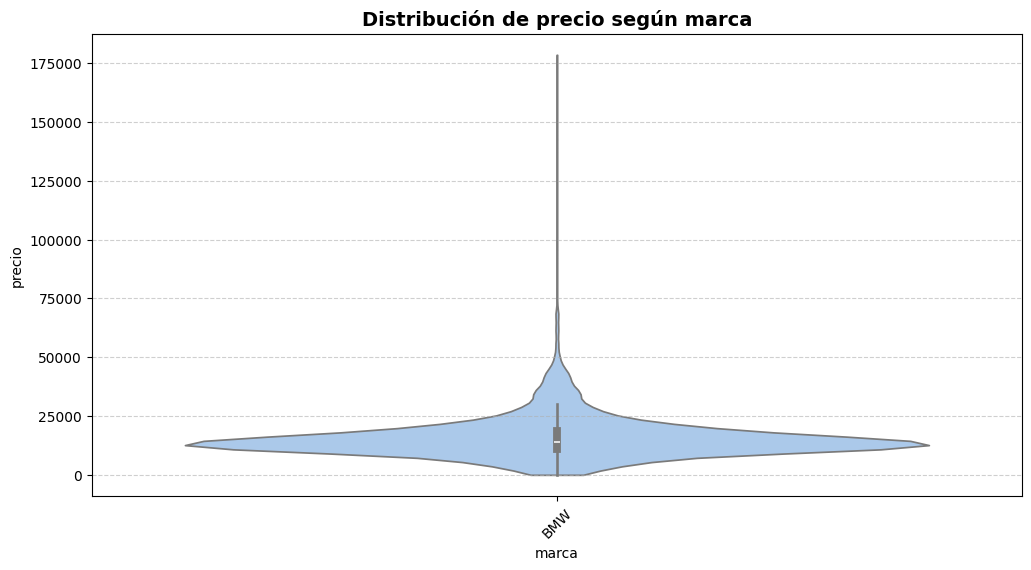

Frecuencia Absoluta  Frecuencia Relativa (%)
marca                                              
BMW                   3873                    79.97
NaN                    970                    20.03

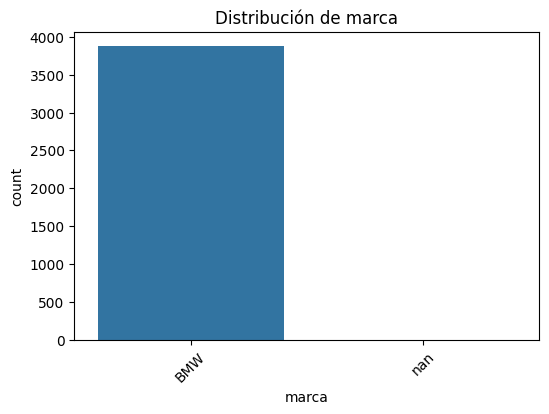




Columna: modelo
------------------------------
Tipo: Categórica
Nº de categorías únicas: 76
Moda: 320


/tmp/ipython-input-2481574662.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=column_name, y=target_column, data=df, palette="pastel", cut=0)


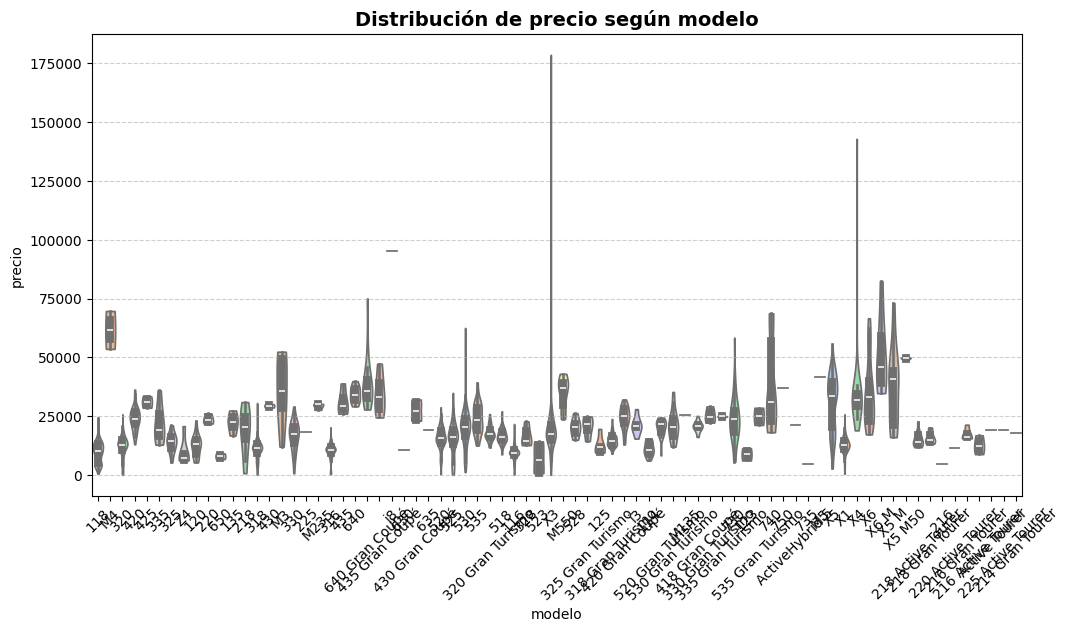

Frecuencia Absoluta  Frecuencia Relativa (%)
modelo                                                         
320                                752                    15.53
520                                633                    13.07
318                                568                    11.73
X3                                 438                     9.04
116                                358                     7.39
...                                ...                      ...
216                                  1                     0.02
220 Active Tourer                    1                     0.02
 Active Tourer                       1                     0.02
225 Active Tourer                    1                     0.02
214 Gran Tourer                      1                     0.02

[77 rows x 2 columns]

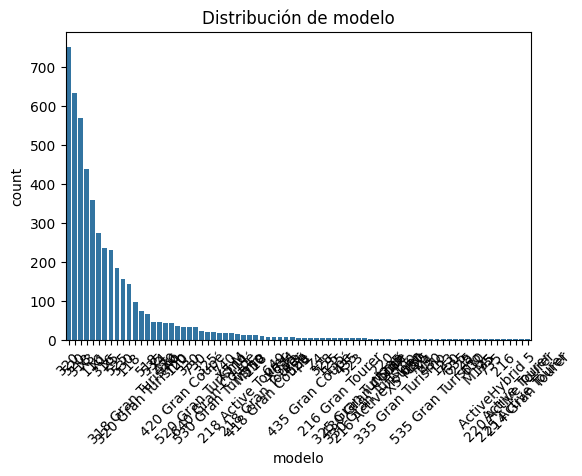




Columna: km
------------------------------
Tipo: Numérica

Estadísticas descriptivas:
count    4.841000e+03
mean     1.409593e+05
std      6.020853e+04
min     -6.400000e+01
25%      1.028840e+05
50%      1.410800e+05
75%      1.752170e+05
max      1.000376e+06
Name: km, dtype: float64





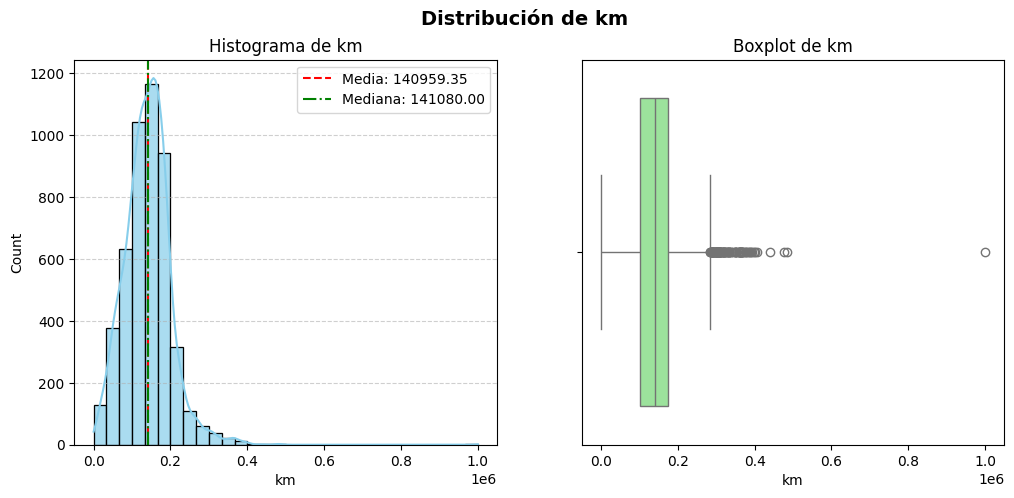




Columna: potencia
------------------------------
Tipo: Numérica

Estadísticas descriptivas:
count    4842.000000
mean      128.981826
std        38.994839
min         0.000000
25%       100.000000
50%       120.000000
75%       135.000000
max       423.000000
Name: potencia, dtype: float64





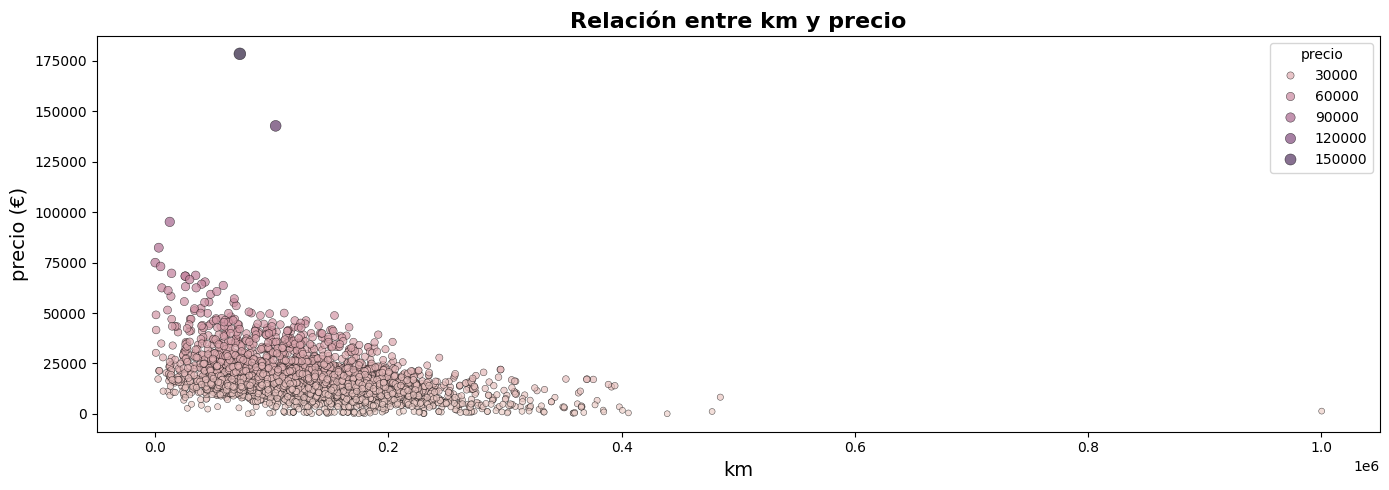

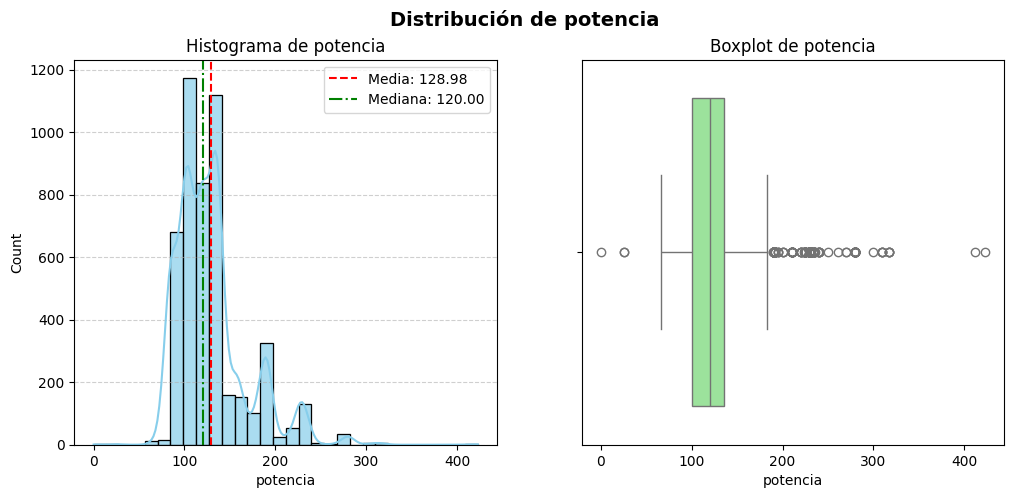




Columna: fecha_registro
------------------------------
Tipo: Categórica
Nº de categorías únicas: 180
Moda: 2013-07-01


/tmp/ipython-input-2481574662.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=column_name, y=target_column, data=df, palette="pastel", cut=0)


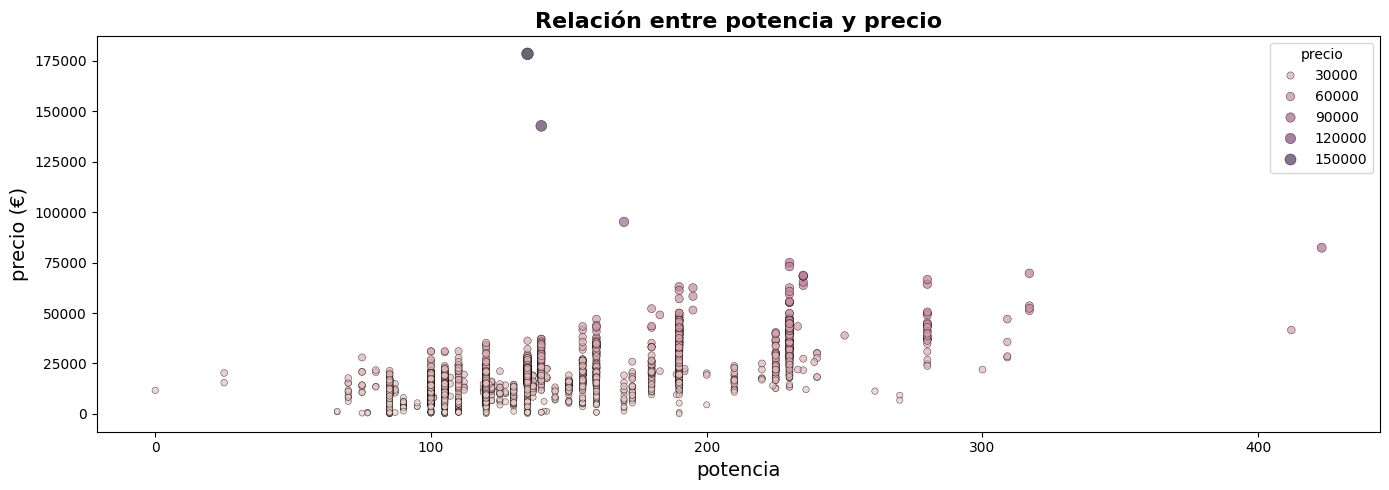

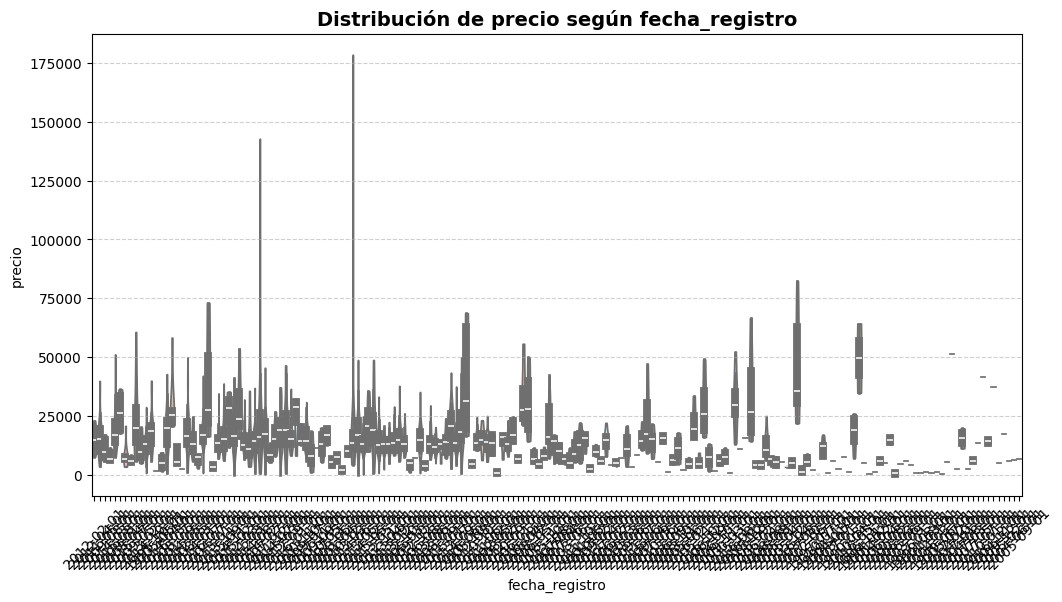

Frecuencia Absoluta  Frecuencia Relativa (%)
fecha_registro                                              
NaN                            2423                    50.03
2013-07-01                       93                     1.92
2014-03-01                       83                     1.71
2014-05-01                       81                     1.67
2013-01-01                       78                     1.61
...                             ...                      ...
2004-11-01                        1                     0.02
2009-12-01                        1                     0.02
2005-02-01                        1                     0.02
2004-06-01                        1                     0.02
2005-09-01                        1                     0.02

[181 rows x 2 columns]

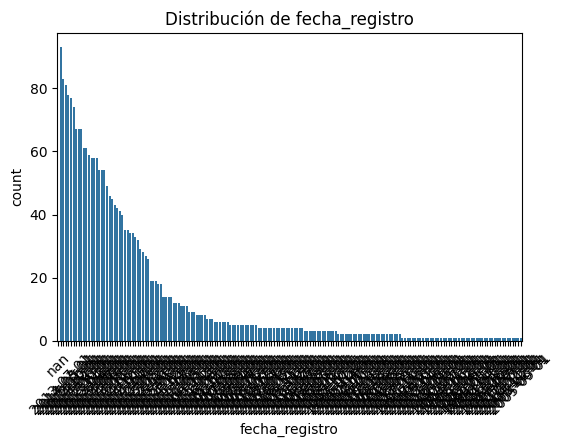




Columna: tipo_gasolina
------------------------------
Tipo: Categórica
Nº de categorías únicas: 5
Moda: diesel


/tmp/ipython-input-2481574662.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=column_name, y=target_column, data=df, palette="pastel", cut=0)


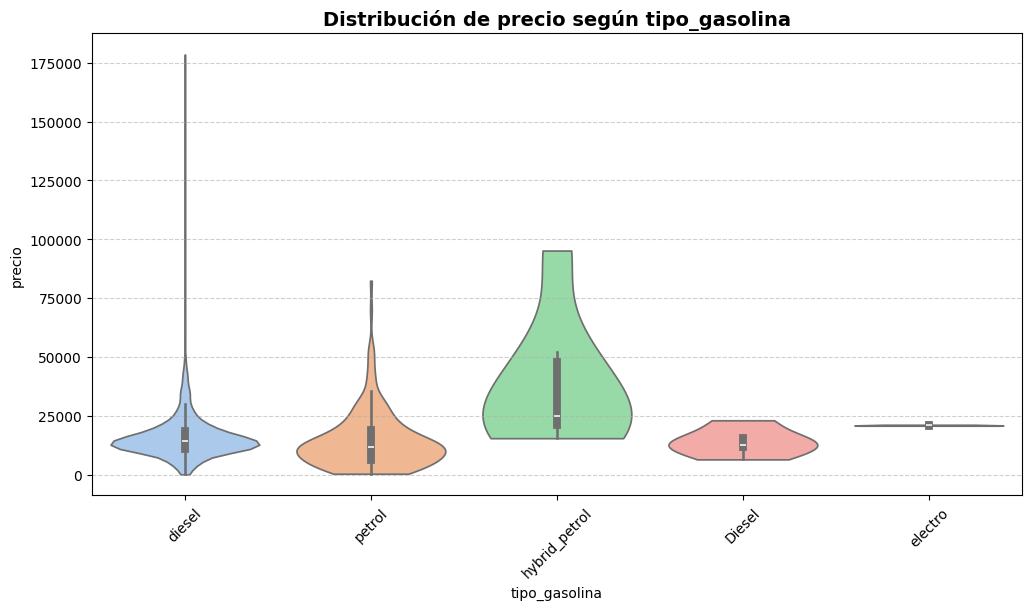

Frecuencia Absoluta  Frecuencia Relativa (%)
tipo_gasolina                                              
diesel                        4631                    95.62
petrol                         191                     3.94
hybrid_petrol                    8                     0.17
NaN                              5                     0.10
Diesel                           5                     0.10
electro                          3                     0.06

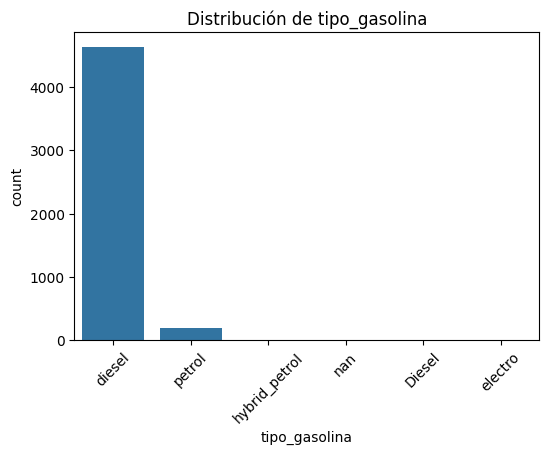




Columna: color
------------------------------
Tipo: Categórica
Nº de categorías únicas: 10
Moda: black


/tmp/ipython-input-2481574662.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=column_name, y=target_column, data=df, palette="pastel", cut=0)


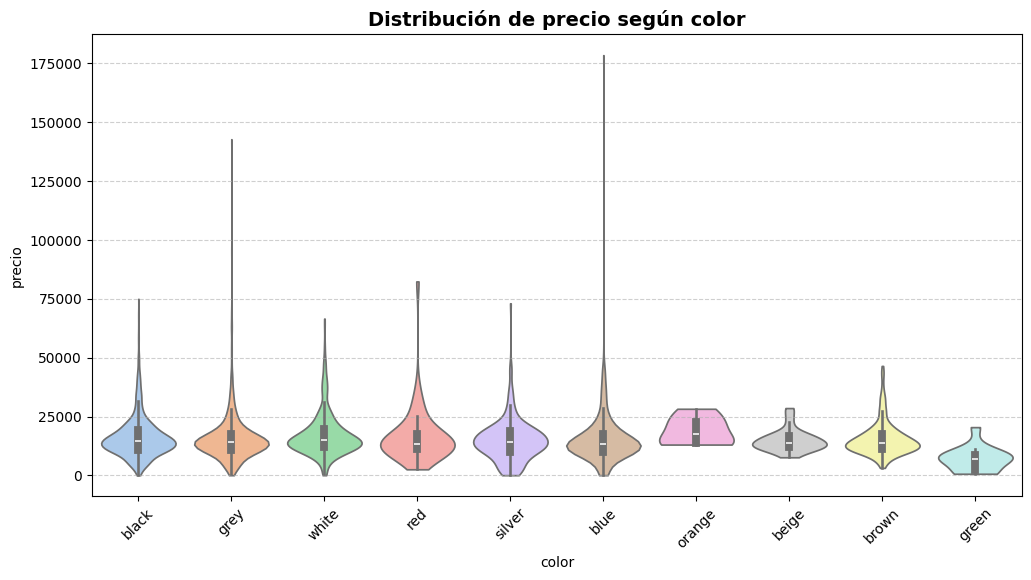

Frecuencia Absoluta  Frecuencia Relativa (%)
color                                               
black                  1499                    30.95
grey                   1070                    22.09
blue                    647                    13.36
white                   484                     9.99
NaN                     445                     9.19
brown                   302                     6.24
silver                  292                     6.03
red                      47                     0.97
beige                    37                     0.76
green                    14                     0.29
orange                    6                     0.12

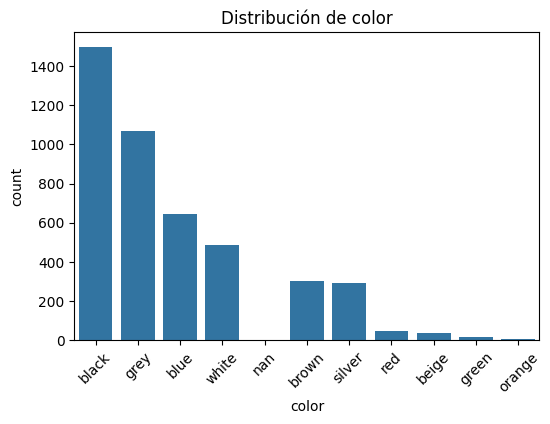




Columna: tipo_coche
------------------------------
Tipo: Categórica
Nº de categorías únicas: 8
Moda: estate


/tmp/ipython-input-2481574662.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=column_name, y=target_column, data=df, palette="pastel", cut=0)


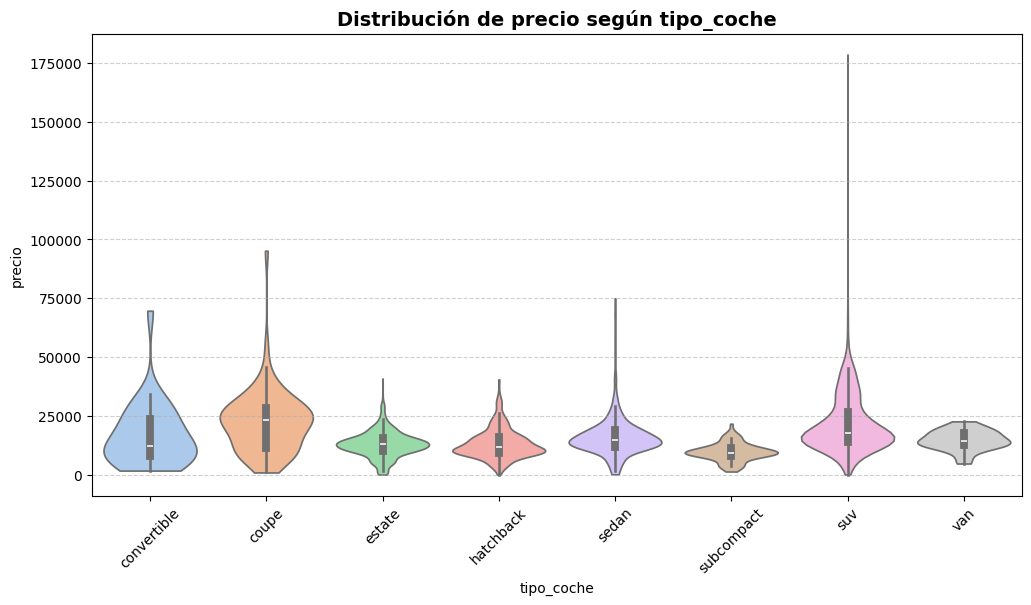

Frecuencia Absoluta  Frecuencia Relativa (%)
tipo_coche                                               
NaN                         1460                    30.15
estate                      1107                    22.86
sedan                        821                    16.95
suv                          755                    15.59
hatchback                    488                    10.08
subcompact                    77                     1.59
coupe                         76                     1.57
convertible                   30                     0.62
van                           29                     0.60

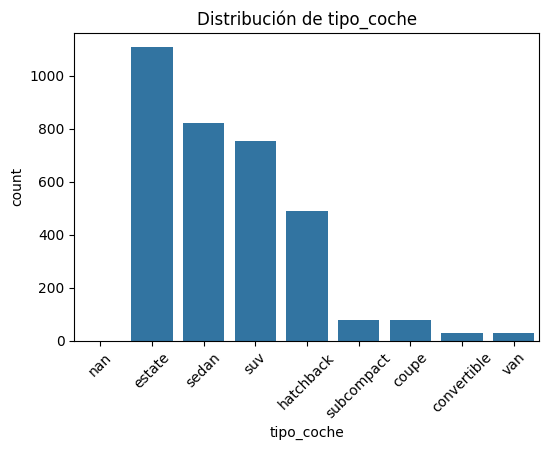




Columna: volante_regulable
------------------------------
Tipo: Categórica
Nº de categorías únicas: 2
Moda: True


/tmp/ipython-input-2481574662.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=column_name, y=target_column, data=df, palette="pastel", cut=0)


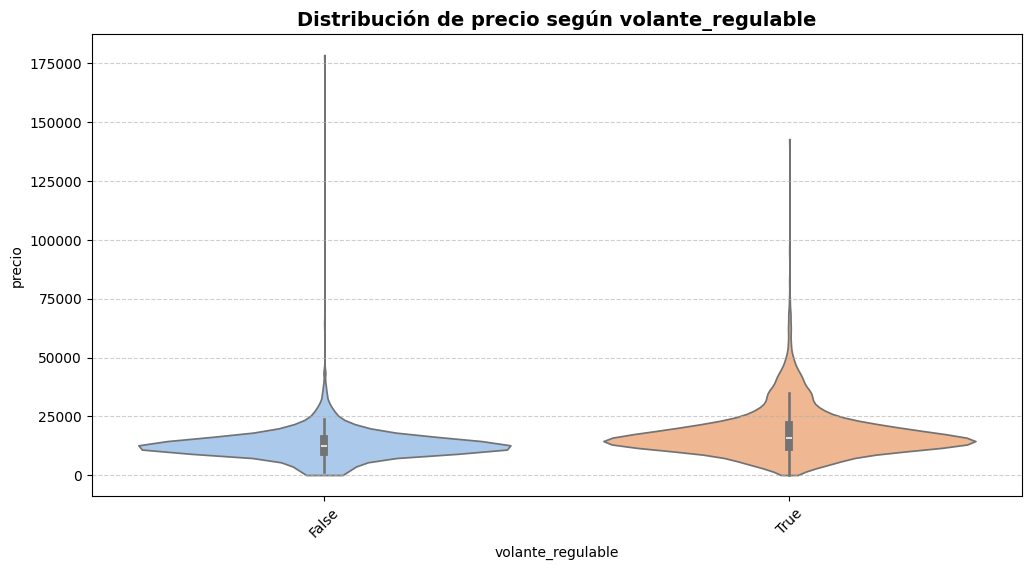

Frecuencia Absoluta  Frecuencia Relativa (%)
volante_regulable                                              
True                              2662                    54.97
False                             2177                    44.95
NaN                                  4                     0.08

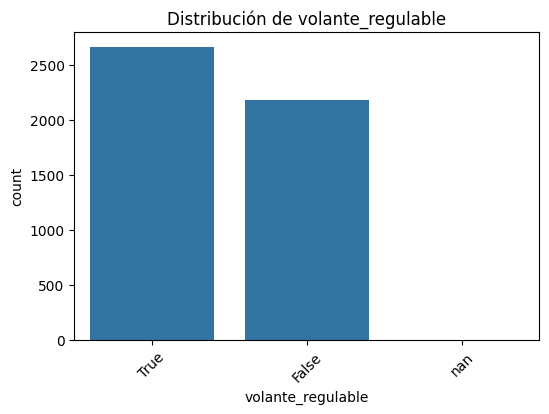




Columna: aire_acondicionado
------------------------------
Tipo: Categórica
Nº de categorías únicas: 2
Moda: True


/tmp/ipython-input-2481574662.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=column_name, y=target_column, data=df, palette="pastel", cut=0)


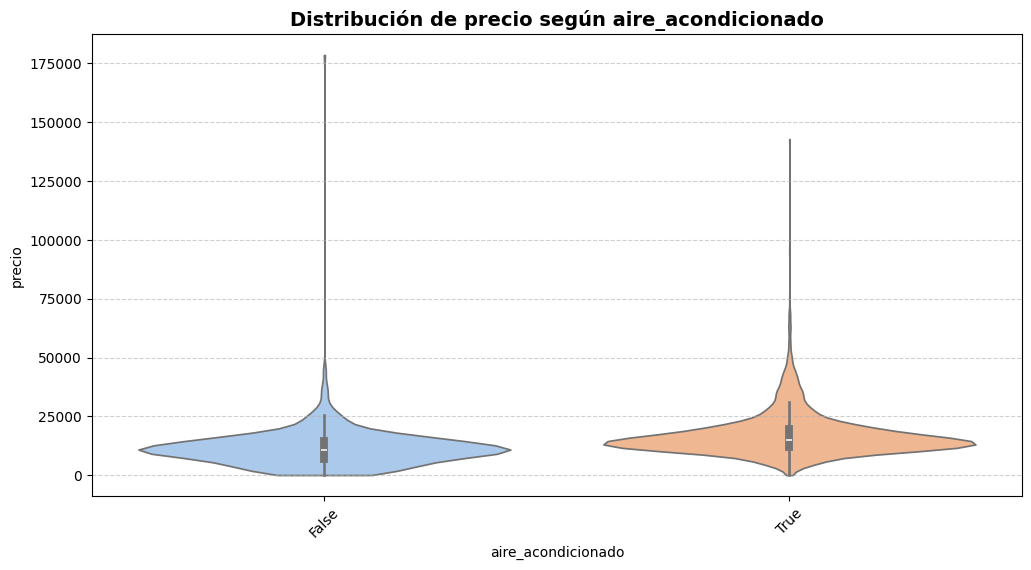

Frecuencia Absoluta  Frecuencia Relativa (%)
aire_acondicionado                                              
True                               3465                    71.55
False                               892                    18.42
NaN                                 486                    10.04

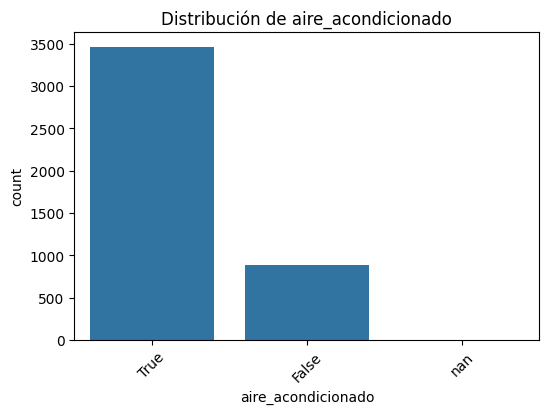




Columna: camara_trasera
------------------------------
Tipo: Categórica
Nº de categorías únicas: 2
Moda: False


/tmp/ipython-input-2481574662.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=column_name, y=target_column, data=df, palette="pastel", cut=0)


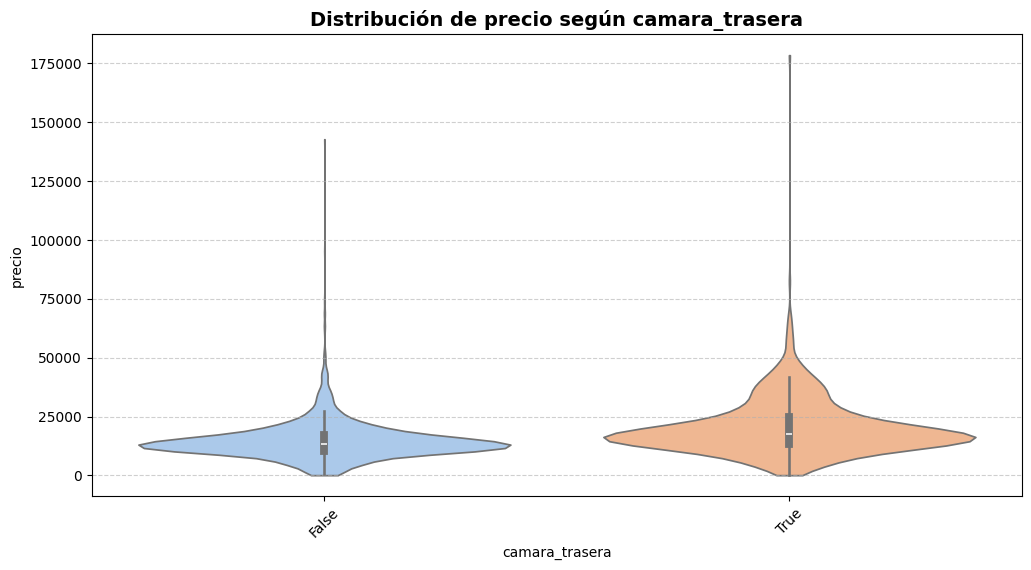

Frecuencia Absoluta  Frecuencia Relativa (%)
camara_trasera                                              
False                          3864                    79.79
True                            977                    20.17
NaN                               2                     0.04

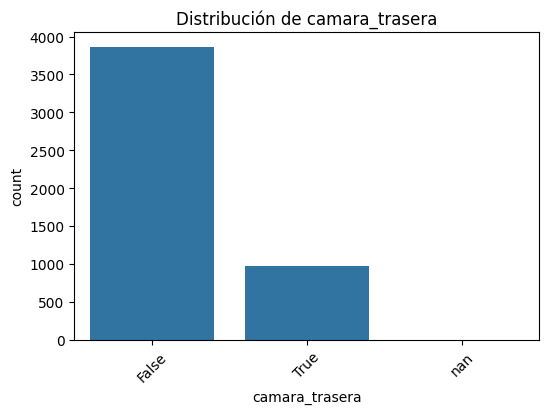




Columna: asientos_traseros_plegables
------------------------------
Tipo: Categórica
Nº de categorías únicas: 2
Moda: False


/tmp/ipython-input-2481574662.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=column_name, y=target_column, data=df, palette="pastel", cut=0)


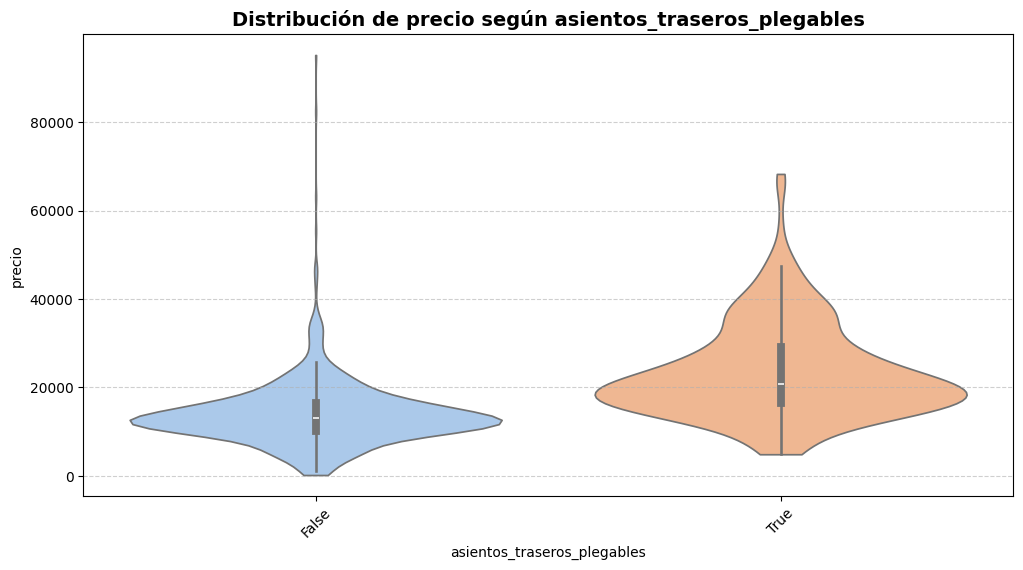

Frecuencia Absoluta  Frecuencia Relativa (%)
asientos_traseros_plegables                                              
NaN                                         3391                    70.02
False                                       1150                    23.75
True                                         302                     6.24

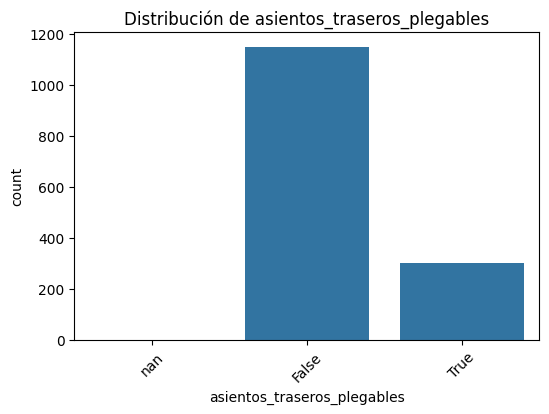




Columna: elevalunas_electrico
------------------------------
Tipo: Categórica
Nº de categorías únicas: 2
Moda: False


/tmp/ipython-input-2481574662.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=column_name, y=target_column, data=df, palette="pastel", cut=0)


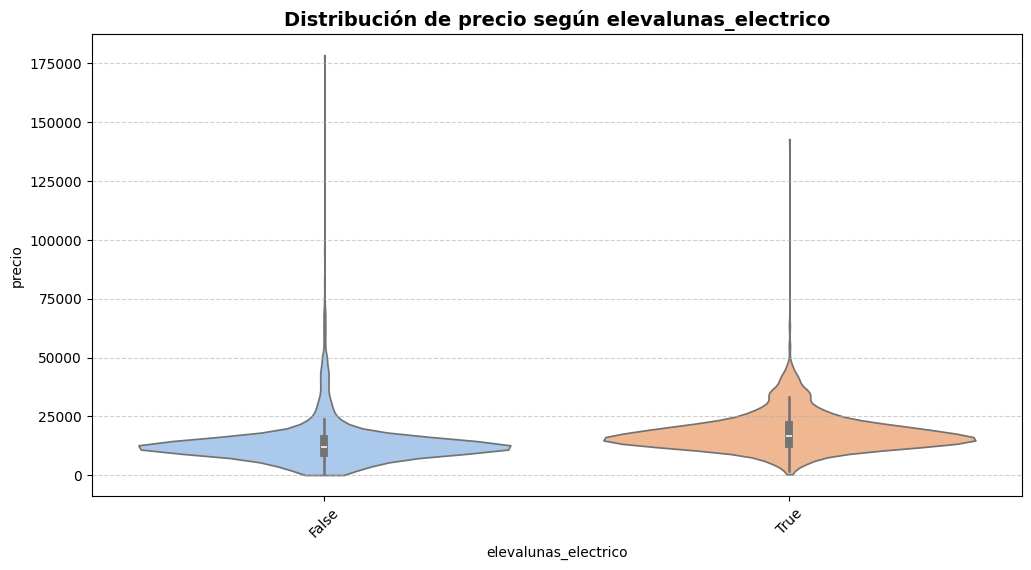

Frecuencia Absoluta  Frecuencia Relativa (%)
elevalunas_electrico                                              
False                                2612                    53.93
True                                 2229                    46.03
NaN                                     2                     0.04

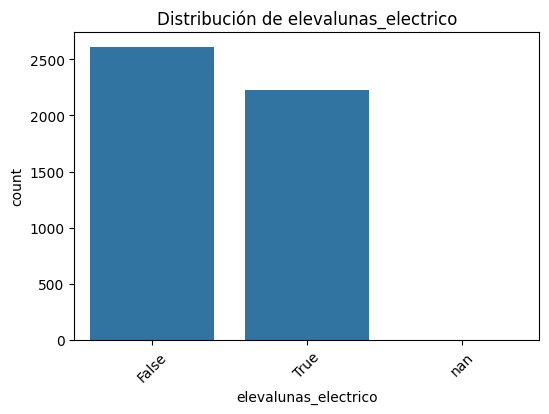




Columna: bluetooth
------------------------------
Tipo: Categórica
Nº de categorías únicas: 2
Moda: False


/tmp/ipython-input-2481574662.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=column_name, y=target_column, data=df, palette="pastel", cut=0)


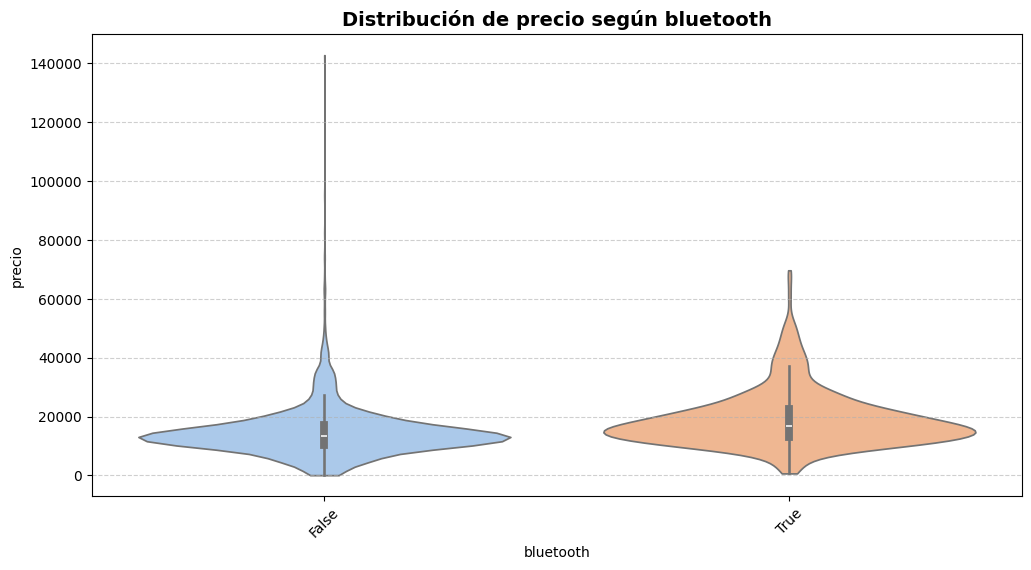

Frecuencia Absoluta  Frecuencia Relativa (%)
bluetooth                                              
False                     3119                    64.40
True                       996                    20.57
NaN                        728                    15.03

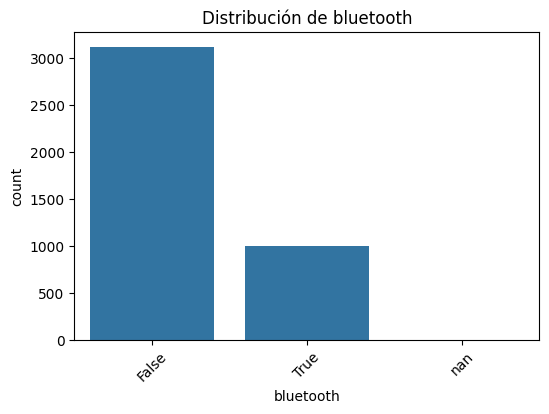




Columna: gps
------------------------------
Tipo: Numérica

Estadísticas descriptivas:
count     4843
unique       2
top       True
freq      4514
Name: gps, dtype: object





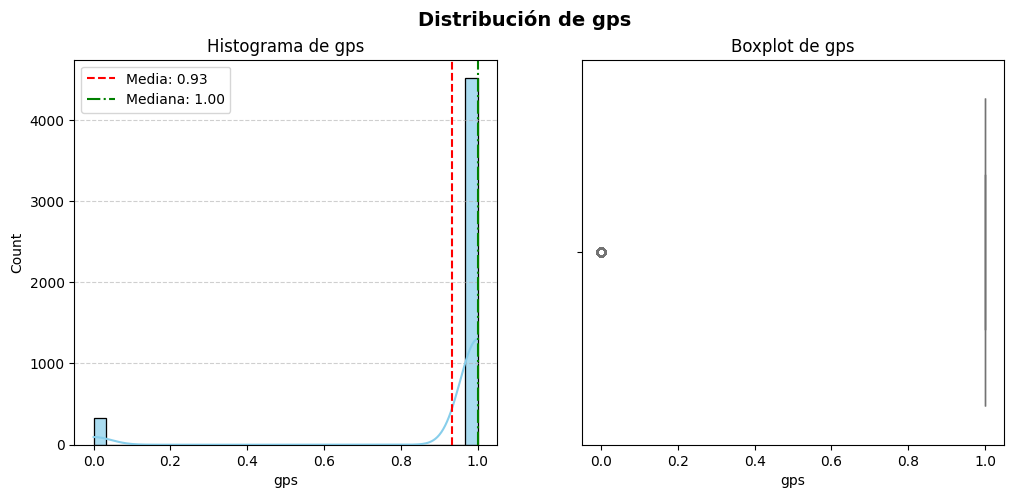




Columna: alerta_lim_velocidad
------------------------------
Tipo: Categórica
Nº de categorías únicas: 2
Moda: True


/tmp/ipython-input-2481574662.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=column_name, y=target_column, data=df, palette="pastel", cut=0)


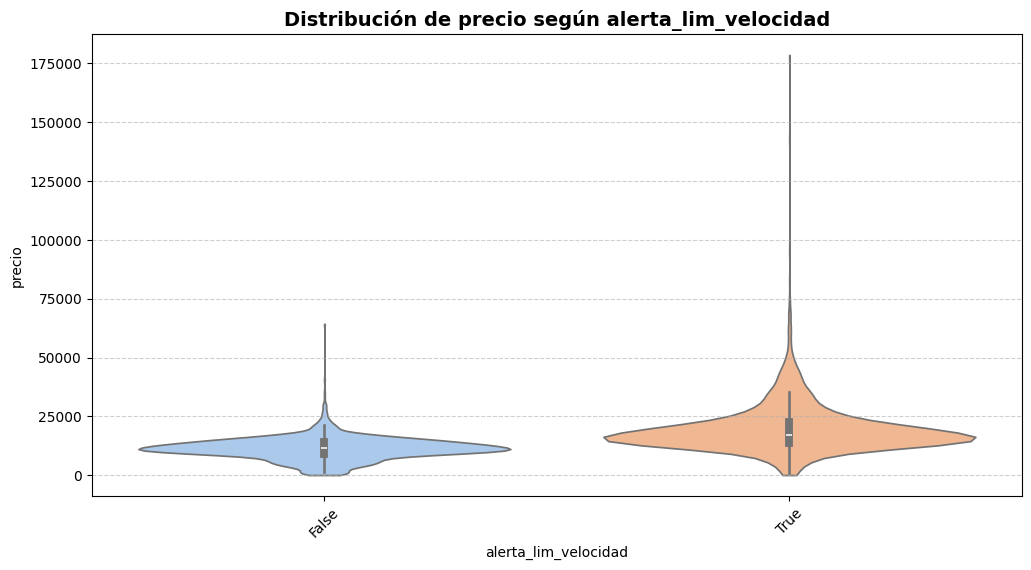

Frecuencia Absoluta  Frecuencia Relativa (%)
alerta_lim_velocidad                                              
True                                 2240                    46.25
False                                1875                    38.72
NaN                                   728                    15.03

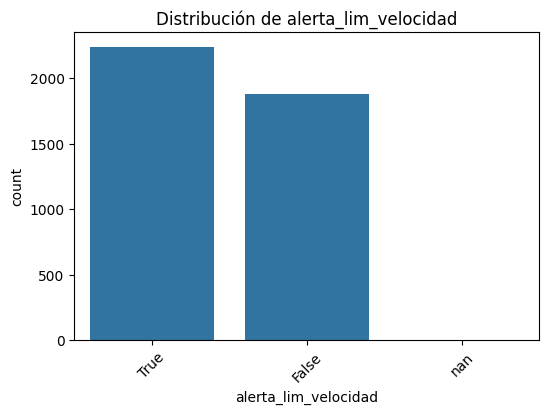




Columna: precio
------------------------------
Tipo: Numérica

Estadísticas descriptivas:
count      4837.000000
mean      15831.920612
std        9222.630708
min         100.000000
25%       10800.000000
50%       14200.000000
75%       18600.000000
max      178500.000000
Name: precio, dtype: float64





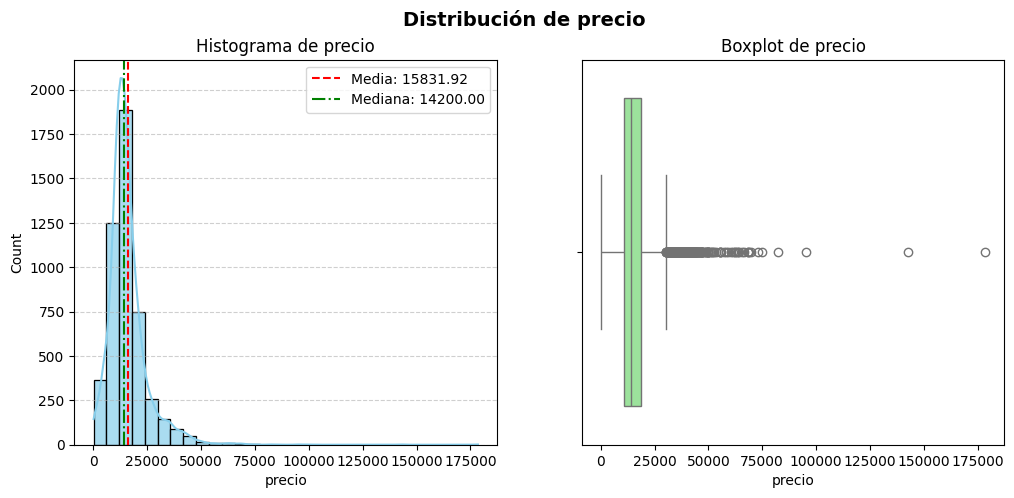




Columna: fecha_venta
------------------------------
Tipo: Categórica
Nº de categorías únicas: 13
Moda: 2018-05-01


/tmp/ipython-input-2481574662.py:289: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=column_name, y=target_column, data=df, palette="pastel", cut=0)


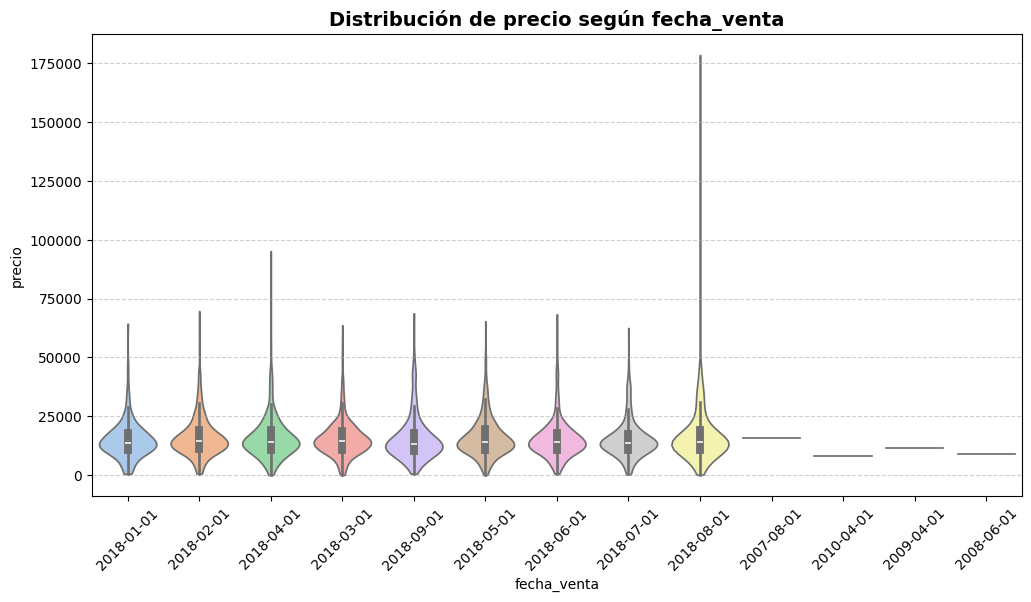

Frecuencia Absoluta  Frecuencia Relativa (%)
fecha_venta                                              
2018-05-01                   809                    16.70
2018-03-01                   738                    15.24
2018-04-01                   691                    14.27
2018-06-01                   603                    12.45
2018-07-01                   537                    11.09
2018-08-01                   527                    10.88
2018-02-01                   502                    10.37
2018-09-01                   223                     4.60
2018-01-01                   208                     4.29
2007-08-01                     1                     0.02
2010-04-01                     1                     0.02
2009-04-01                     1                     0.02
2008-06-01                     1                     0.02
NaN                            1                     0.02

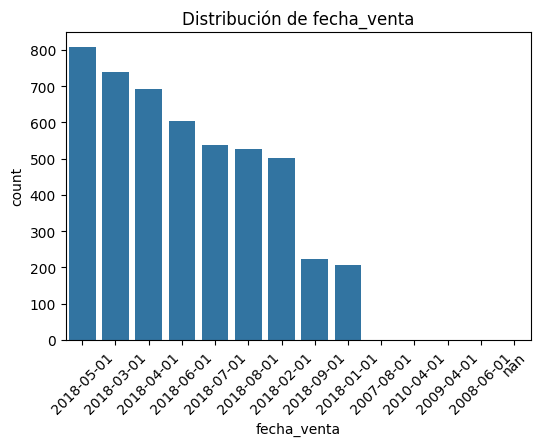

In [7]:
# Análisis exploratorio del dataset (dtypes, histogramas, gráficas de barra, etc.)
analisis_exploratorio(df, target_column="precio", display_categoricas=True, display_numericas=True)

---

## 4. ANÁLISIS DE CALIDAD DE DATOS

### 4.1 Declaración de constantes


In [8]:
# Valores únicos de la columna "modelo"
CONSTANTE_MODELOS = df["modelo"].unique()

### 4.2 Análisis de duplicados

In [9]:
# Verificacion de datos duplicados
df[df.duplicated(keep='first')]

Empty DataFrame
Columns: [marca, modelo, km, potencia, fecha_registro, tipo_gasolina, color, tipo_coche, volante_regulable, aire_acondicionado, camara_trasera, asientos_traseros_plegables, elevalunas_electrico, bluetooth, gps, alerta_lim_velocidad, precio, fecha_venta]
Index: []

### 4.3 Valores nulos

In [10]:
# Obtiene las columnas con NULLS del dataset
null_porcentajes = obtener_columnas_con_nulos(df)
display(obtener_columnas_con_nulos(df))

null_count  null_porcentaje
asientos_traseros_plegables        3391        70.018584
fecha_registro                     2423        50.030973
tipo_coche                         1460        30.146603
marca                               970        20.028908
alerta_lim_velocidad                728        15.032005
bluetooth                           728        15.032005
aire_acondicionado                  486        10.035102
color                               445         9.188520
precio                                6         0.123890
tipo_gasolina                         5         0.103242
volante_regulable                     4         0.082593
modelo                                3         0.061945
elevalunas_electrico                  2         0.041297
km                                    2         0.041297
camara_trasera                        2         0.041297
potencia                              1         0.020648
fecha_venta                           1         0.020648
gps                                   0         0.000000

### 4.4 Valores inconsistentes

#### 4.4.1 Valores inconsistentes - Columna "km"

In [11]:
# Analizando la columna "km"
display(df['km'].describe().T)
print("\n")

# Verificando cantidad de valores negativos en la columna "km"
display(df[df['km'] <= 0])

count    4.841000e+03
mean     1.409593e+05
std      6.020853e+04
min     -6.400000e+01
25%      1.028840e+05
50%      1.410800e+05
75%      1.752170e+05
max      1.000376e+06
Name: km, dtype: float64

marca          modelo    km  potencia fecha_registro tipo_gasolina  color tipo_coche volante_regulable aire_acondicionado camara_trasera asientos_traseros_plegables elevalunas_electrico bluetooth   gps alerta_lim_velocidad   precio fecha_venta
2938   NaN  640 Gran Coupé -64.0     230.0            NaN        diesel  black      sedan              True               True          False                         NaN                False     False  True                 True  75000.0  2018-04-01

#### 4.4.2 Valores inconsistentes - Columna "precio"

In [12]:
# Analizando la columna "precio"
display(df['precio'].describe().T)

count      4837.000000
mean      15831.920612
std        9222.630708
min         100.000000
25%       10800.000000
50%       14200.000000
75%       18600.000000
max      178500.000000
Name: precio, dtype: float64

In [13]:
# Verifica los registros con precio <= 1000 por considerarlos inconsistentes
inconsistencia_precio = df[df['precio'] <= 1000]["precio"].value_counts()
total_precio = df["precio"].value_counts().sum()
porcentaje_inconsistencia_precio = (inconsistencia_precio.sum() / total_precio) * 100

print(f"Total de inconsistencias en la columna 'precio': {inconsistencia_precio.sum()}")
print(f"Porcentaje de inconsistencias en la columna 'precio': {porcentaje_inconsistencia_precio:.2f}%")

# Filtra el dataset por los precios > 1000
df = df[df['precio'] > 1000]

Total de inconsistencias en la columna 'precio': 67
Porcentaje de inconsistencias en la columna 'precio': 1.39%


---

## 5. TRATAMIENTO DE VALORES NULOS
Se decidió implementar como regla de negocio, mantener las columnas cuyos porcentaje de nulos superen el 3%

### 5.1 Análisis de Patrones

In [14]:
# Mostrar todas las columnas con valores nulos que sean menor al 3% de la muestra
regla_supresion_nulos_porc_aceptation = 0.03

columnas_con_maximo_3_porc_nulos = null_porcentajes[(null_porcentajes['null_porcentaje'] > 0) & (null_porcentajes['null_porcentaje'] < (regla_supresion_nulos_porc_aceptation * 100))]

print(f"Columnas con máximo {regla_supresion_nulos_porc_aceptation * 100}% de valores nulos (y más del 0%):\n")
display(columnas_con_maximo_3_porc_nulos)

Columnas con máximo 3.0% de valores nulos (y más del 0%):



null_count  null_porcentaje
precio                         6         0.123890
tipo_gasolina                  5         0.103242
volante_regulable              4         0.082593
modelo                         3         0.061945
elevalunas_electrico           2         0.041297
km                             2         0.041297
camara_trasera                 2         0.041297
potencia                       1         0.020648
fecha_venta                    1         0.020648

In [15]:
# Mostrar una lista cuyas columnas de la variable columnas_con_maximo_3_porc_nulos tenga valores nulos
columnas_a_verificar  = columnas_con_maximo_3_porc_nulos.index.tolist()

filas_con_nulos = df[df[columnas_a_verificar].isnull().any(axis=1)]

if not filas_con_nulos.empty:
    print(f"Número de filas con al menos un null: {len(filas_con_nulos)}\n")
    display(filas_con_nulos)
    print("\n")
else:
    print("No hay filas con valores nulos en columnas especificadas\n")

# Calculando porcentaje de nulos del DataFrame original
impacto_de_nulos_en_dataframe = (filas_con_nulos.shape[0] / df.shape[0]) * 100

print(f'Porcentaje de nulos del DataFrame original: {impacto_de_nulos_en_dataframe}')
print(f'Lista de columnas donde la cantidad de nulos corresponde < 3% del DataFrame: {columnas_a_verificar}')
print(f'La cantidad de columnas a suprimir corresponde al {np.round(impacto_de_nulos_en_dataframe, 4)}% del DataFrame original < {regla_supresion_nulos_porc_aceptation * 100}%')

Número de filas con al menos un null: 18



marca modelo        km  potencia fecha_registro tipo_gasolina   color tipo_coche volante_regulable aire_acondicionado camara_trasera asientos_traseros_plegables elevalunas_electrico bluetooth    gps alerta_lim_velocidad   precio fecha_venta
63     NaN    640   69695.0     230.0     2012-04-01        diesel     NaN      coupe              True               True          False                         NaN                  NaN      True   True                 True  36300.0  2018-02-01
66     BMW    320   93066.0     135.0     2013-01-01        diesel   black      coupe               NaN              False          False                         NaN                 True     False   True                  NaN  11900.0  2018-06-01
82     NaN    420   54993.0     135.0            NaN           NaN   black        NaN             False              False          False                       False                False     False  False                False  18400.0  2018-03-01
173    BMW    NaN  146338.0     105.0            NaN        diesel   black        NaN             False               True          False                         NaN                False       NaN   True                  NaN  13300.0  2018-08-01
181    BMW    525  106054.0       NaN     2014-05-01        diesel   black     estate             False               True          False                         NaN                False     False   True                 True  18700.0  2018-03-01
185    BMW    320  186697.0     135.0     2012-11-01           NaN   white     estate             False              False          False                         NaN                False     False  False                 True   2400.0  2018-04-01
273    BMW    318  195032.0     100.0     2008-01-01        diesel    grey        NaN               NaN                NaN          False                       False                False     False   True                False   4900.0  2018-01-01
291    NaN    520  163675.0     135.0     2011-12-01        diesel     NaN     estate              True               True            NaN                         NaN                 True       NaN   True                 True  14900.0  2018-01-01
305    BMW    535  148738.0     230.0            NaN        diesel    grey     estate              True               True           True                         NaN                  NaN     False   True                 True  28800.0  2018-01-01
409    BMW    316  160619.0      85.0            NaN        diesel   black     estate             False               True            NaN                         NaN                 True       NaN   True                  NaN  11700.0  2018-04-01
444    BMW    318  111622.0     100.0     2013-01-01           NaN   black     estate              True               True          False                         NaN                False     False   True                 True  15400.0  2018-02-01
459    BMW    520       NaN     135.0     2012-12-01        diesel   black        NaN              True               True           True                       False                 True      True   True                 True  20300.0  2018-02-01
480    BMW    318  170350.0     105.0            NaN           NaN   white        NaN             False               True          False                         NaN                False     False   True                False  10200.0  2018-02-01
489    NaN    320  227691.0     135.0            NaN        diesel   black        NaN               NaN               True          False                       False                False      True   True                False  10500.0  2018-02-01
594    BMW    525  269290.0     120.0            NaN        diesel  silver        NaN              True              False           True                         NaN                False     False   True                 True   4200.0         NaN
614    NaN    318  201626.0     105.0     2013-10-01        diesel   



Porcentaje de nulos del DataFrame original: 0.37735849056603776
Lista de columnas donde la cantidad de nulos corresponde < 3% del DataFrame: ['precio', 'tipo_gasolina', 'volante_regulable', 'modelo', 'elevalunas_electrico', 'km', 'camara_trasera', 'potencia', 'fecha_venta']
La cantidad de columnas a suprimir corresponde al 0.3774% del DataFrame original < 3.0%


### 5.2 Implementación

#### 5.2.1 Supresión de filas inferior al 3% de nulos

In [16]:
# Creando una copia del DataFrame
df_clean_nulos_menor_3_porc = df.copy(deep=True)

# Obtener la lista de indices de las filas a suprimir
rows_to_drop_indices = filas_con_nulos.index

# Elimina las filas por el índice
df_clean_nulos_menor_3_porc = df_clean_nulos_menor_3_porc.drop(rows_to_drop_indices)

print(f"DataFrame original shape: {df.shape}")
print(f"Filas con nulos shape: {filas_con_nulos.shape}")
print(f"Nuevo DataFrame, 'df_clean_nulos_menor_3_porc', shape: {df_clean_nulos_menor_3_porc.shape}\n")

display(df_clean_nulos_menor_3_porc.head())

DataFrame original shape: (4770, 18)
Filas con nulos shape: (18, 18)
Nuevo DataFrame, 'df_clean_nulos_menor_3_porc', shape: (4752, 18)



marca modelo        km  potencia fecha_registro tipo_gasolina   color   tipo_coche volante_regulable aire_acondicionado camara_trasera asientos_traseros_plegables elevalunas_electrico bluetooth   gps alerta_lim_velocidad   precio fecha_venta
0   NaN    118  140411.0     100.0     2012-02-01        diesel   black          NaN              True               True          False                         NaN                 True       NaN  True                  NaN  11300.0  2018-01-01
1   BMW     M4   13929.0     317.0            NaN        petrol    grey  convertible              True               True          False                         NaN                False      True  True                 True  69700.0  2018-02-01
2   BMW    320  183297.0     120.0     2012-04-01        diesel   white          NaN             False              False          False                         NaN                 True     False  True                False  10200.0  2018-02-01
3   BMW    420  128035.0     135.0            NaN        diesel     red  convertible              True               True          False                         NaN                 True      True  True                  NaN  25100.0  2018-02-01
4   BMW    425   97097.0     160.0            NaN        diesel  silver          NaN              True               True          False                       False                False      True  True                 True  33400.0  2018-04-01

In [17]:
# Obtiene las columnas con NULLS del nuevo DataFrame
display(obtener_columnas_con_nulos(df_clean_nulos_menor_3_porc))

null_count  null_porcentaje
asientos_traseros_plegables        3322        69.907407
fecha_registro                     2375        49.978956
tipo_coche                         1432        30.134680
marca                               956        20.117845
alerta_lim_velocidad                719        15.130471
bluetooth                           717        15.088384
aire_acondicionado                  473         9.953704
color                               435         9.154040
modelo                                0         0.000000
tipo_gasolina                         0         0.000000
volante_regulable                     0         0.000000
km                                    0         0.000000
potencia                              0         0.000000
camara_trasera                        0         0.000000
elevalunas_electrico                  0         0.000000
gps                                   0         0.000000
precio                                0         0.000000
fecha_venta                           0         0.000000

#### 5.2.2 Filas superiores al 3% de nulos

In [18]:
# Mostrar las columnas donde hay más de un null
display(df_clean_nulos_menor_3_porc.isnull().sum()[df_clean_nulos_menor_3_porc.isnull().sum() > 0])

marca                           956
fecha_registro                 2375
color                           435
tipo_coche                     1432
aire_acondicionado              473
asientos_traseros_plegables    3322
bluetooth                       717
alerta_lim_velocidad            719
dtype: int64

#### 5.2.2.1 Filas superiores al 3% de nulos: Columna "marca"

In [19]:
display(tratamiento_columna_marca(df_clean_nulos_menor_3_porc))

Lista de modelos exclusivos para la 'marca' = NULL con su cantidad de ocurrencias:



modelo  cantidad_modelos
0  220 Active Tourer                 1
1  225 Active Tourer                 1
2                630                 1
3               M235                 3

None

Podemos confirmar que los modelos que se encuentran de forma exclusiva en "marca" = NULL corresponden a la marca BMW también, entonces esta columna no genera valor por lo que podemos suprimirla

In [20]:
# Supresión de columna "marca" porque se trata de un DataFrame BMW
df_clean_nulos_marca = df_clean_nulos_menor_3_porc.copy(deep=True)
df_clean_nulos_marca = df_clean_nulos_marca.drop(columns=["marca"])

#### 5.2.2.2 Filas superiores al 3% de nulos: Columna "fecha_registro"
La estrategia para la actualización de la columna "fecha_registro" = NULL:

1.   Conversión a formato datetime de la columna "fecha_registro" y "fecha_venta".

2.   Crear una columna nueva "diff_registro_venta" y realizar la resta entre "fecha_venta" y "fecha_registro" para calcular el tiempo transcurrido para la venta.

3.   Calcular la media de la columna "diff_registro_venta" según el modelo.

4.   Calcular fecha_registro (fecha_venta - (la media de la columna MODELO."diff_registro_venta")

5.   Realizar actualización de valores nulos para la columna "fecha_registro"
6.   Borrar filas restantes de la columna "fecha_registro" sin actualizar (media en null).

In [21]:
df_clean_nulos_fecha_registro = df_clean_nulos_marca.copy(deep=True)

# Obtiene las columnas con NULLS del dataset
display(obtener_columnas_con_nulos(df_clean_nulos_fecha_registro))

null_count  null_porcentaje
asientos_traseros_plegables        3322        69.907407
fecha_registro                     2375        49.978956
tipo_coche                         1432        30.134680
alerta_lim_velocidad                719        15.130471
bluetooth                           717        15.088384
aire_acondicionado                  473         9.953704
color                               435         9.154040
modelo                                0         0.000000
tipo_gasolina                         0         0.000000
volante_regulable                     0         0.000000
km                                    0         0.000000
potencia                              0         0.000000
camara_trasera                        0         0.000000
elevalunas_electrico                  0         0.000000
gps                                   0         0.000000
precio                                0         0.000000
fecha_venta                           0         0.000000

In [22]:
# 1. Transformando el formato de las columnas "fecha_registro" y "fecha_venta" a datetime
transformar_columnas_fechas = ["fecha_registro", "fecha_venta"]
for idx in transformar_columnas_fechas:
    df_clean_nulos_fecha_registro[idx] = pd.to_datetime(df_clean_nulos_fecha_registro[idx])


# 2. Función para el cálculo de tiempo realizado entre la "fecha_registro" y "fecha_venta" del vehículo
def update_diff_registro_menos_venta(df: pd.DataFrame) -> pd.DataFrame:
    """
        Crea la columna "diff_registro_venta"

        Args:
            df: DataFrame a analizar

        Return:
            DataFrame con la columna "diff_registro_venta"
    """
    df["diff_registro_venta"]  = np.round((df["fecha_registro"] - df["fecha_venta"]) / np.timedelta64(1, 'D'))
    return df


# 3. Calcular la media de la columna "diff_registro_venta" según el modelo
def calcular_mean_modelo(df: pd.DataFrame, modelo_id: str, display_log: bool = False) -> float:
    """
        Calcula la media de la columna "diff_registro_venta"

        Args:
            df: DataFrame a analizar
            modelo_id: Identificador del modelo
            display_log (Opcional): True para mostrar el log (default = False)

        Return:
            Media de la columna "diff_registro_venta"
    """
    mean__model_no_nulls = df[df["modelo"] == modelo_id]["diff_registro_venta"].dropna().mean()
    if(display_log):
        print(f"La media de la columna '' para modelo {modelo_id} es: {mean__model_no_nulls}")

    return np.abs(mean__model_no_nulls)


# 4. Calcular fecha_registro (fecha_venta - (la media de la columna MODELO."diff_registro_venta")
def calcular_fecha_registro(fecha_venta_serie: pd.Series, media_en_dias: float):
    """
        Calcula la fecha_registro (fecha_venta - (la media de la columna MODELO."diff_registro_venta"))

        Args:
            fecha_venta_serie: Serie de la columna "fecha_venta"
            media_en_dias: Media de la columna

        Return:
            Fecha_registro
    """
    # Conversión de time
    time_difference = pd.to_timedelta(np.abs(media_en_dias), unit='D')
    estimated_fecha_registro = fecha_venta_serie - time_difference
    return estimated_fecha_registro


# Actualización de la columna "fecha_registro
def update_fecha_registro(df: pd.DataFrame, modelo_id: str, media_en_minutos: float, update_data: bool = True):
    estimated_fecha_registro_values = None

    if np.isnan(media_en_minutos):
        print(f"Nulls en la variable 'media_en_minutos' para el modelo {str(modelo_id)}")
    else:
        # Crear un boolean mask para las filas donde se encuentre el modelo y la fecha_registro en NULL
        mask_rows_to_fill = (df["modelo"] == str(modelo_id)) & (df["fecha_registro"].isnull())

        # Proceder si se encuentran filas
        if mask_rows_to_fill.any():
            # Calcular la fecha_registro
            estimated_fecha_registro_values = calcular_fecha_registro(df.loc[mask_rows_to_fill, "fecha_venta"], media_en_minutos)

            # Rellenar los valores de la columna fecha_registro con el valor de la variable 'estimated_fecha_registro_values'
            if update_data:
                df.loc[mask_rows_to_fill, "fecha_registro"] = estimated_fecha_registro_values

    return modelo_id, estimated_fecha_registro_values


# 5. Realizar actualización de valores nulos para la columna "fecha_registro"
def tratamiento_fecha_registro(df: pd.DataFrame, actualizar_registro: bool = False):
    modelos_list = df["modelo"].unique()
    valores_nulos_media = list()        # Registros con media null

    for modelo_id in modelos_list:
        media_en_minutos = calcular_mean_modelo(df, modelo_id)

        if np.isnan(media_en_minutos):
            valores_nulos_media.append(modelo_id)
        else:
            # Pass update_data=True to actually modify the dataframe
            update_fecha_registro(df, modelo_id, media_en_minutos, actualizar_registro)

    print(f"Cantidad de fechas registro sin actualizar por falta de media: ", df[df["modelo"].isin(valores_nulos_media) & df["fecha_registro"].isnull()].shape[0])
    return valores_nulos_media


# 6. Suprimir fecha_registro nulos restantes
def supression_fecha_registro_null(df: pd.DataFrame, columnas, update_data: bool = False) -> None:
    print(f"Cantidad de filas antes de la supresión de filas: {df.shape[0]}")

    # Calcular el número de filas que serán eliminadas
    cantidad_filas_a_eliminar = df[df[columnas].isnull().any(axis=1)].shape[0]
    print(f"Número de filas que serán eliminadas {columnas}: {cantidad_filas_a_eliminar}")

    if update_data:
        df.dropna(subset=columnas, axis=0, inplace=True)
    print(f"Cantidad de filas después de la supresión de filas: {df.shape[0]}\n")

In [23]:
df_clean_nulos_fecha_registro = update_diff_registro_menos_venta(df_clean_nulos_fecha_registro)
print("\n")
display(df_clean_nulos_fecha_registro.info(5))
print("\n")
tratamiento_fecha_registro(df_clean_nulos_fecha_registro, True)
print("\n")
display(obtener_columnas_con_nulos(df_clean_nulos_fecha_registro))



<class 'pandas.core.frame.DataFrame'>
Index: 4752 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   modelo                       4752 non-null   object        
 1   km                           4752 non-null   float64       
 2   potencia                     4752 non-null   float64       
 3   fecha_registro               2377 non-null   datetime64[ns]
 4   tipo_gasolina                4752 non-null   object        
 5   color                        4317 non-null   object        
 6   tipo_coche                   3320 non-null   object        
 7   volante_regulable            4752 non-null   object        
 8   aire_acondicionado           4279 non-null   object        
 9   camara_trasera               4752 non-null   object        
 10  asientos_traseros_plegables  1430 non-null   object        
 11  elevalunas_electrico         4752 non-null   o

None



Cantidad de fechas registro sin actualizar por falta de media:  20




null_count  null_porcentaje
asientos_traseros_plegables        3322        69.907407
diff_registro_venta                2375        49.978956
tipo_coche                         1432        30.134680
alerta_lim_velocidad                719        15.130471
bluetooth                           717        15.088384
aire_acondicionado                  473         9.953704
color                               435         9.154040
fecha_registro                       20         0.420875
km                                    0         0.000000
modelo                                0         0.000000
camara_trasera                        0         0.000000
volante_regulable                     0         0.000000
potencia                              0         0.000000
tipo_gasolina                         0         0.000000
gps                                   0         0.000000
elevalunas_electrico                  0         0.000000
precio                                0         0.000000
fecha_venta                           0         0.000000

In [24]:
columnas = ["fecha_registro"]

# Suprime la fecha_registro nulos restantes
supression_fecha_registro_null(df_clean_nulos_fecha_registro, columnas, True)
display(obtener_columnas_con_nulos(df_clean_nulos_fecha_registro))

Cantidad de filas antes de la supresión de filas: 4752
Número de filas que serán eliminadas ['fecha_registro']: 20
Cantidad de filas después de la supresión de filas: 4732



null_count  null_porcentaje
asientos_traseros_plegables        3312        69.991547
diff_registro_venta                2355        49.767540
tipo_coche                         1426        30.135249
bluetooth                           717        15.152156
alerta_lim_velocidad                716        15.131023
aire_acondicionado                  472         9.974641
color                               434         9.171598
modelo                                0         0.000000
km                                    0         0.000000
potencia                              0         0.000000
camara_trasera                        0         0.000000
volante_regulable                     0         0.000000
fecha_registro                        0         0.000000
tipo_gasolina                         0         0.000000
gps                                   0         0.000000
elevalunas_electrico                  0         0.000000
precio                                0         0.000000
fecha_venta                           0         0.000000

#### 5.2.2.3 Filas superiores al 3% de nulos: Columna "color"

In [25]:
# Tratamiento de valores nulos para la columna "color", agregar moda de la columna según el "modelo"
df_clean_nulos_color = df_clean_nulos_fecha_registro.copy(deep=True)
df_clean_nulos_color = tratamiento_columna_color(df_clean_nulos_color)
print("\n")
display(obtener_columnas_con_nulos(df_clean_nulos_color))

La moda para la columna 'color', modelo '120' es blue
La moda para la columna 'color', modelo '325' es blue
La moda para la columna 'color', modelo '318' es black
La moda para la columna 'color', modelo '420' es black
La moda para la columna 'color', modelo '118' es black
La moda para la columna 'color', modelo '640' es blue
La moda para la columna 'color', modelo '320' es black
La moda para la columna 'color', modelo '218' es grey
La moda para la columna 'color', modelo '525' es black
La moda para la columna 'color', modelo '520' es grey
La moda para la columna 'color', modelo '535' es black
La moda para la columna 'color', modelo '316' es grey
La moda para la columna 'color', modelo '335' es black
La moda para la columna 'color', modelo '518' es black
La moda para la columna 'color', modelo '530' es black
La moda para la columna 'color', modelo '325 Gran Turismo' es black
La moda para la columna 'color', modelo '330' es grey
La moda para la columna 'color', modelo '116' es black
La m

/tmp/ipython-input-2481574662.py:104: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  mode_result = df.loc[filtro, column_name].mode(dropna=False)


null_count  null_porcentaje
asientos_traseros_plegables        3312        69.991547
diff_registro_venta                2355        49.767540
tipo_coche                         1426        30.135249
bluetooth                           717        15.152156
alerta_lim_velocidad                716        15.131023
aire_acondicionado                  472         9.974641
km                                    0         0.000000
modelo                                0         0.000000
potencia                              0         0.000000
fecha_registro                        0         0.000000
camara_trasera                        0         0.000000
volante_regulable                     0         0.000000
tipo_gasolina                         0         0.000000
color                                 0         0.000000
gps                                   0         0.000000
elevalunas_electrico                  0         0.000000
precio                                0         0.000000
fecha_venta                           0         0.000000

#### 5.2.2.4 Filas superiores al 3% de nulos: Columna "tipo_coche"

In [26]:
# Tratamiento de valores nulos para la columna "tipo_coche", rellena con valor "no_indicado"
df_clean_nulos_tipo_coche = df_clean_nulos_color.copy(deep=True)
df_clean_nulos_tipo_coche["tipo_coche"].unique()

# Obtiene el conteo absoluto (incluyendo NaN) y porcentaje con respecto al total de la columna "tipo_coche"
resultado = describe_columna_value_accounts(df_clean_nulos_tipo_coche, "tipo_coche")
print("Conteo absoluto y porcentaje de la columna 'tipo_coche':\n")
display(resultado)
print("\n")

# Actualizar la columna "tipo_coche" = NULL con el valor "no_indicado"
df_clean_nulos_tipo_coche = tratamiento_columna_tipo_coche(df_clean_nulos_tipo_coche)
print("\n")

# Obtiene el nuevo conteo absoluto (incluyendo NaN) y porcentaje con respecto al total de la columna "tipo_coche"
resultado = describe_columna_value_accounts(df_clean_nulos_tipo_coche, "tipo_coche")
print("Nuevo conteo absoluto y porcentaje de la columna 'tipo_coche':\n")
display(resultado)
print("\n")

display(obtener_columnas_con_nulos(df_clean_nulos_tipo_coche))

Conteo absoluto y porcentaje de la columna 'tipo_coche':



count  percentage
tipo_coche                    
NaN           1426       30.14
estate        1074       22.70
sedan          802       16.95
suv            747       15.79
hatchback      484       10.23
subcompact      77        1.63
coupe           67        1.42
convertible     29        0.61
van             26        0.55



La moda para la columna 'tipo_coche', modelo '118' es hatchback
La moda para la columna 'tipo_coche', modelo '320' es estate
Advertencia: La moda para la columna 'tipo_coche' del modelo 335 es NaN. Los nulos no serán rellenados para este modelo.
Advertencia: La moda para la columna 'tipo_coche' del modelo 325 es NaN. Los nulos no serán rellenados para este modelo.
La moda para la columna 'tipo_coche', modelo '420' es coupe
La moda para la columna 'tipo_coche', modelo 'Z4' es convertible
La moda para la columna 'tipo_coche', modelo '220' es convertible
Advertencia: La moda para la columna 'tipo_coche' del modelo 430 es NaN. Los nulos no serán rellenados para este modelo.
La moda para la columna 'tipo_coche', modelo '120' es hatchback
Advertencia: La moda para la columna 'tipo_coche' del modelo M3 es NaN. Los nulos no serán rellenados para este modelo.
Advertencia: La moda para la columna 'tipo_coche' del modelo 218 es NaN. Los nulos no serán rellenados para este modelo.
La moda para l

/tmp/ipython-input-2481574662.py:104: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  mode_result = df.loc[filtro, column_name].mode(dropna=False)
/tmp/ipython-input-2481574662.py:104: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  mode_result = df.loc[filtro, column_name].mode(dropna=False)
/tmp/ipython-input-2481574662.py:104: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  mode_result = df.loc[filtro, column_name].mode(dropna=False)
/tmp/ipython-input-2481574662.py:104: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  mode_result = df.loc[filtro, column_name].mode(dropna=False)
/tmp/ipython-input-2481574662.py:104: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  mode_result = df.loc[filtro, column_name].mode(dropna=False)
/tmp/ipython-input-2481574662.py:10

count  percentage
tipo_coche                    
estate        1761       37.21
suv           1051       22.21
sedan          914       19.32
hatchback      742       15.68
coupe           79        1.67
subcompact      77        1.63
no_indicado     43        0.91
van             33        0.70
convertible     32        0.68

null_count  null_porcentaje
asientos_traseros_plegables        3312        69.991547
diff_registro_venta                2355        49.767540
bluetooth                           717        15.152156
alerta_lim_velocidad                716        15.131023
aire_acondicionado                  472         9.974641
modelo                                0         0.000000
km                                    0         0.000000
potencia                              0         0.000000
tipo_gasolina                         0         0.000000
fecha_registro                        0         0.000000
camara_trasera                        0         0.000000
volante_regulable                     0         0.000000
tipo_coche                            0         0.000000
color                                 0         0.000000
gps                                   0         0.000000
elevalunas_electrico                  0         0.000000
precio                                0         0.000000
fecha_venta                           0         0.000000

#### 5.2.2.5 Filas superiores al 3% de nulos: Columnas "aire_acondicionado", "asientos_traseros_plegables", "bluetooth" y "alerta_lim_velocidad"

In [27]:
df_clean_nulos_otros = df_clean_nulos_tipo_coche.copy(deep=True)

columnas_boolean_adicionales = [
    "aire_acondicionado",
    "asientos_traseros_plegables",
    "bluetooth",
    "alerta_lim_velocidad"
]

for col in columnas_boolean_adicionales:
    # Obtiene el conteo absoluto (incluyendo NaN) y porcentaje con respecto al total de la columna col
    resultado = describe_columna_value_accounts(df_clean_nulos_otros, col)
    print(f"Conteo absoluto y porcentaje de la columna '{col}':\n")
    display(resultado)
    print("\n")

    # Crea nueva columna numérica a partir de la columna booleana col
    df_clean_nulos_otros = create_boolean_column_to_numerica(df_clean_nulos_otros, col)

    # Obtiene el conteo absoluto (incluyendo NaN) y porcentaje con respecto al total de la columna col + "_number"
    resultado = describe_columna_value_accounts(df_clean_nulos_otros, col + "_number")
    print(f"Conteo absoluto y porcentaje de la columna '{col}_number':\n")
    display(resultado)
    print("\n" + "=" * 80, "\n")

# Eliminación de columnas "aire_acondicionado", "asientos_traseros_plegables", "bluetooth" y "alerta_lim_velocidad"
suprimir_columna(df_clean_nulos_otros, columnas_boolean_adicionales)
print("\n")

display(obtener_columnas_con_nulos(df_clean_nulos_otros))
df_clean = df_clean_nulos_otros

Conteo absoluto y porcentaje de la columna 'aire_acondicionado':



count  percentage
aire_acondicionado                   
True                 3421       72.30
False                 839       17.73
NaN                   472        9.97



Columna 'aire_acondicionado' actualizada a 'aire_acondicionado_number'

Conteo absoluto y porcentaje de la columna 'aire_acondicionado_number':



count  percentage
aire_acondicionado_number                   
 1.0                        3421       72.30
 0.0                         839       17.73
-1.0                         472        9.97



Conteo absoluto y porcentaje de la columna 'asientos_traseros_plegables':



count  percentage
asientos_traseros_plegables                   
NaN                           3312       69.99
False                         1119       23.65
True                           301        6.36



Columna 'asientos_traseros_plegables' actualizada a 'asientos_traseros_plegables_number'

Conteo absoluto y porcentaje de la columna 'asientos_traseros_plegables_number':



count  percentage
asientos_traseros_plegables_number                   
-1.0                                 3312       69.99
 0.0                                 1119       23.65
 1.0                                  301        6.36



Conteo absoluto y porcentaje de la columna 'bluetooth':



count  percentage
bluetooth                   
False       3037       64.18
True         978       20.67
NaN          717       15.15



Columna 'bluetooth' actualizada a 'bluetooth_number'

Conteo absoluto y porcentaje de la columna 'bluetooth_number':



count  percentage
bluetooth_number                   
 0.0               3037       64.18
 1.0                978       20.67
-1.0                717       15.15



Conteo absoluto y porcentaje de la columna 'alerta_lim_velocidad':



count  percentage
alerta_lim_velocidad                   
True                   2192       46.32
False                  1824       38.55
NaN                     716       15.13



Columna 'alerta_lim_velocidad' actualizada a 'alerta_lim_velocidad_number'

Conteo absoluto y porcentaje de la columna 'alerta_lim_velocidad_number':



count  percentage
alerta_lim_velocidad_number                   
 1.0                          2192       46.32
 0.0                          1824       38.55
-1.0                           716       15.13



Columna 'aire_acondicionado' suprimida
Columna 'asientos_traseros_plegables' suprimida
Columna 'bluetooth' suprimida
Columna 'alerta_lim_velocidad' suprimida




null_count  null_porcentaje
diff_registro_venta                       2355         49.76754
modelo                                       0          0.00000
km                                           0          0.00000
potencia                                     0          0.00000
tipo_gasolina                                0          0.00000
fecha_registro                               0          0.00000
tipo_coche                                   0          0.00000
volante_regulable                            0          0.00000
camara_trasera                               0          0.00000
color                                        0          0.00000
elevalunas_electrico                         0          0.00000
gps                                          0          0.00000
precio                                       0          0.00000
fecha_venta                                  0          0.00000
aire_acondicionado_number                    0          0.00000
asientos_traseros_plegables_number           0          0.00000
bluetooth_number                             0          0.00000
alerta_lim_velocidad_number                  0          0.00000

---

## 6. DETECCIÓN Y TRATAMIENTO DE OUTLIERS

### 6.1 Variables Numéricas

In [28]:
# Visualiza la información de las variables numéricas
display(df_clean.select_dtypes(exclude=['object','bool']).describe().T)

count                           mean                  min                            25%                  50%                  75%                  max           std
km                                  4732.0                  140276.069104                -64.0                       102523.0             140539.5            175018.75            1000376.0  59196.452643
potencia                            4732.0                     128.965342                  0.0                          100.0                120.0                135.0                423.0     38.635631
fecha_registro                        4732  2013-01-01 10:05:26.947460608  1990-03-01 00:00:00  2012-08-22 14:53:22.266288896  2013-01-12 08:32:00  2013-11-01 00:00:00  2017-11-01 00:00:00           NaN
precio                              4732.0                   16021.196112               1100.0                        11000.0              14300.0              18800.0             178500.0   9030.963717
fecha_venta                           4732     2018-04-26 21:56:08.723584  2007-08-01 00:00:00            2018-03-01 00:00:00  2018-05-01 00:00:00  2018-07-01 00:00:00  2018-09-01 00:00:00           NaN
diff_registro_venta                 2377.0                   -1942.586454             -10258.0                        -2130.0              -1765.0              -1489.0               2009.0    844.562296
aire_acondicionado_number           4732.0                       0.623204                 -1.0                            0.0                  1.0                  1.0                  1.0      0.659094
asientos_traseros_plegables_number  4732.0                      -0.636306                 -1.0                           -1.0                 -1.0                  0.0                  1.0      0.598929
bluetooth_number                    4732.0                       0.055156                 -1.0                            0.0                  0.0                  0.0                  1.0      0.596014
alerta_lim_velocidad_number         4732.0                       0.311919                 -1.0                            0.0                  0.0                  1.0                  1.0      0.719274

### 6.2 Visualización

#### 6.2.1 Visualización: Columna "precio"

array([[<Axes: title={'center': 'precio'}>]], dtype=object)

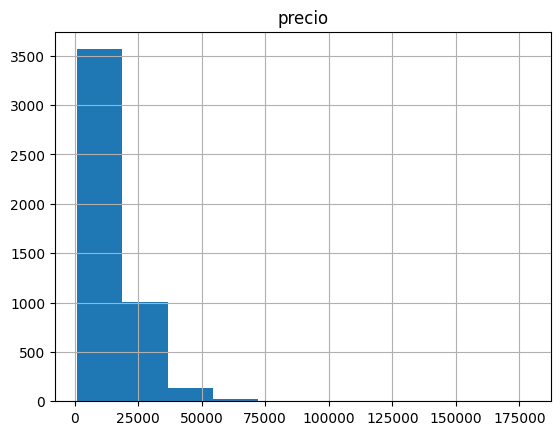

In [29]:
# Histograma de la columna "precio"
df_clean.hist("precio")

<Axes: xlabel='precio'>

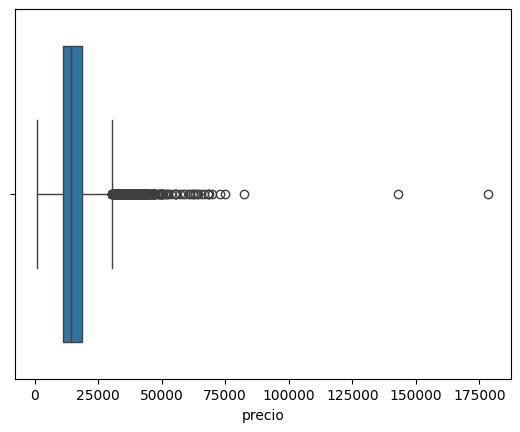

In [30]:
# Boxplot de la columna "precio"
sns.boxplot(x=df_clean["precio"])

In [31]:
# Supresión outlier > 100000
df_clean = df_clean[df_clean["precio"] <= 100000]
display(df_clean["precio"].describe())

count     4730.000000
mean     15960.042283
std       8521.022825
min       1100.000000
25%      11000.000000
50%      14300.000000
75%      18700.000000
max      82400.000000
Name: precio, dtype: float64

<Axes: xlabel='precio'>

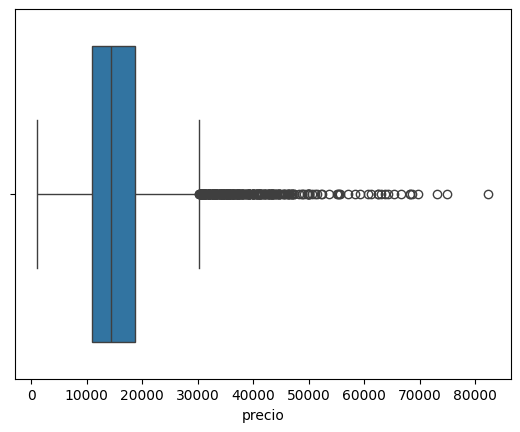

In [32]:
# Boxplot posterior a eliminar los outlier > 100000
sns.boxplot(x=df_clean["precio"])

##### Se ve que la variable "precio" esta sesgada, se decide crear una nueva variable llamada "log_precio" para normalizarla.

/tmp/ipython-input-2761185021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["log_precio"] = np.log10(df_clean["precio"])


array([[<Axes: title={'center': 'log_precio'}>]], dtype=object)

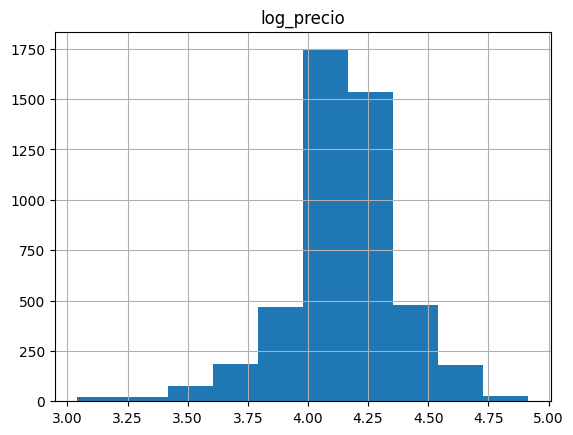

In [33]:
# Normalización de la variable "precio"
df_clean["log_precio"] = np.log10(df_clean["precio"])

# Histograma de la nueva columna normalizada "log_precio"
df_clean.hist("log_precio")

### 6.3 Tratamiento

In [34]:
# Verificando cantidad de valores negativos en la columna "km"
display(df_clean[df_clean["km"]<=0])

# Suprimir los valores negativos de la columna "km"
df_clean = df_clean.drop(df_clean[df_clean['km'] < 0].index)

modelo    km  potencia                fecha_registro tipo_gasolina  color tipo_coche volante_regulable camara_trasera elevalunas_electrico   gps   precio fecha_venta  diff_registro_venta  aire_acondicionado_number  asientos_traseros_plegables_number  bluetooth_number  alerta_lim_velocidad_number  log_precio
2938  640 Gran Coupé -64.0     230.0 2014-05-10 06:51:25.714285707        diesel  black      sedan              True          False                False  True  75000.0  2018-04-01                  NaN                        1.0                                -1.0               0.0                          1.0    4.875061

---

## 7. TRANSFORMACIÓN DE VARIABLES

### 7.1 Variables Categóricas

In [35]:
# Visualiza la información de las variables categóricas y booleanas
display(df_clean.select_dtypes(include=['object', 'bool']).describe().T)

count unique     top  freq
modelo                4729     63     320   728
tipo_gasolina         4729      5  diesel  4546
color                 4729     10   black  1813
tipo_coche            4729      9  estate  1761
volante_regulable     4729      2    True  2625
camara_trasera        4729      2   False  3772
elevalunas_electrico  4729      2   False  2526
gps                   4729      2    True  4429

#### Encontramos las columnas "volante_regulable", "camara_trasera", "elevalunas_electrico" y "gps" en True y False, por lo que serán sustituídas a:

*   True = 1
*   False = 0

A las columnas "tipo_coche", "color", "tipo_gasolina" y "modelo" se le aplicará OHE.

### 7.2 Variables Numéricas

In [36]:
# Visualiza la información de las variables numéricas
display(df_clean.select_dtypes(exclude=['object', 'bool']).describe().T)

count                           mean                  min                            25%                  50%                  75%                  max           std
km                                  4729.0                  140327.909918                476.0                       102677.0             140586.0             175024.0            1000376.0  59169.363577
potencia                            4729.0                     128.940368                  0.0                          100.0                120.0                135.0                423.0     38.619503
fecha_registro                        4729  2013-01-01 04:21:39.393036800  1990-03-01 00:00:00  2012-08-22 14:53:22.266288896  2013-01-12 08:32:00  2013-11-01 00:00:00  2017-11-01 00:00:00           NaN
precio                              4729.0                   15947.557623               1100.0                        11000.0              14300.0              18700.0              82400.0   8478.548305
fecha_venta                           4729  2018-04-26 21:05:31.148234240  2007-08-01 00:00:00            2018-03-01 00:00:00  2018-05-01 00:00:00  2018-07-01 00:00:00  2018-09-01 00:00:00           NaN
diff_registro_venta                 2375.0                   -1942.773895             -10258.0                        -2130.0              -1765.0              -1489.0               2009.0     844.85981
aire_acondicionado_number           4729.0                       0.623176                 -1.0                            0.0                  1.0                  1.0                  1.0      0.659196
asientos_traseros_plegables_number  4729.0                      -0.636075                 -1.0                           -1.0                 -1.0                  0.0                  1.0      0.599048
bluetooth_number                    4729.0                       0.055403                 -1.0                            0.0                  0.0                  0.0                  1.0      0.596004
alerta_lim_velocidad_number         4729.0                       0.311482                 -1.0                            0.0                  0.0                  1.0                  1.0      0.719293
log_precio                          4729.0                       4.147333             3.041393                       4.041393             4.155336             4.271842             4.915927      0.227384

---

## 8. FEATURE ENGINEERING
### Aquí es donde se hace el procesamiento y transformación del dataset, como One-Hot Encoding a las variables categóricas, Scaling de variables numéricas, etc

In [37]:
df_encoded = df_clean.copy(deep=True)

### 8.1 Feature engineering: Variables Categóricas

#### 8.1.1 Variables Categóricas: Columnas booleanas

In [38]:
# Transformación de columnas booleanas a numéricas
lista_columns_boolean = [
    "volante_regulable",
    "camara_trasera",
    "elevalunas_electrico",
    "gps"
]

for col in lista_columns_boolean:
    # Crear nueva columna numérica a partir de la columna booleana col
    df_encoded = create_boolean_column_to_numerica(df_encoded, col)

# Eliminación de columnas de lista_columns_boolean
suprimir_columna(df_encoded, lista_columns_boolean)

Columna 'volante_regulable' actualizada a 'volante_regulable_number'

Columna 'camara_trasera' actualizada a 'camara_trasera_number'

Columna 'elevalunas_electrico' actualizada a 'elevalunas_electrico_number'

Columna 'gps' actualizada a 'gps_number'

Columna 'volante_regulable' suprimida
Columna 'camara_trasera' suprimida
Columna 'elevalunas_electrico' suprimida
Columna 'gps' suprimida


#### 8.1.2 Variables Categóricas: Columnas object

In [39]:
display(df_encoded.select_dtypes(include=['object', 'bool']).describe().T)

count unique     top  freq
modelo         4729     63     320   728
tipo_gasolina  4729      5  diesel  4546
color          4729     10   black  1813
tipo_coche     4729      9  estate  1761

##### 8.1.2.1 Variables Categóricas: Columna "modelo"

In [40]:
# Mostrar todas las filas sin truncar
pd.set_option('display.max_rows', None)

df_encoded['modelo'].value_counts(normalize=True).sort_values(ascending=False)

modelo
320                  0.153944
520                  0.132375
318                  0.116515
X3                   0.091563
116                  0.075492
X1                   0.056883
X5                   0.048848
316                  0.047367
525                  0.036794
530                  0.033199
118                  0.030027
318 Gran Turismo     0.020512
320 Gran Turismo     0.015437
518                  0.013956
535                  0.009516
X4                   0.009516
X6                   0.009304
420                  0.008881
120                  0.007613
420 Gran Coupé       0.006978
730                  0.006978
330                  0.006767
520 Gran Turismo     0.004864
325                  0.004018
640 Gran Coupé       0.003806
740                  0.003806
530 Gran Turismo     0.003806
X5 M                 0.003595
114                  0.003172
218 Active Tourer    0.002749
M550                 0.002538
218                  0.002326
218 Gran Tourer      0.001903
X6 M                 0.001692
418 Gran Coupé       0.001692
640                  0.001480
M3                   0.001480
335                  0.001480
528                  0.001269
435 Gran Coupé       0.001269
Z4                   0.001269
i3                   0.001269
125                  0.001057
328                  0.001057
135                  0.000846
435                  0.000846
430 Gran Coupé       0.000846
216 Gran Tourer      0.000846
325 Gran Turismo     0.000846
335 Gran Turismo     0.000634
220                  0.000634
216 Active Tourer    0.000634
X5 M50               0.000634
330 Gran Turismo     0.000634
M4                   0.000423
750                  0.000423
430                  0.000423
635                  0.000211
M135                 0.000211
ActiveHybrid 5       0.000211
220 Active Tourer    0.000211
 Active Tourer       0.000211
214 Gran Tourer      0.000211
Name: proportion, dtype: float64

In [41]:
# Eliminar las filas con el modelo = " Active Tourer" y "ActiveHybrid 5" por no tener formato para la agrupación que se hará por los números de serie
# Al ser pocos registros, podemos eliminarlas
modelos_a_borrar = df_encoded[df_encoded['modelo'].isin([" Active Tourer", "ActiveHybrid 5"])]
df_encoded = df_encoded.drop(modelos_a_borrar.index)

# Crea columna "modelo_codigo" con el número de serie del modelo (los 3 primeros dígitos)
df_encoded['modelo_codigo'] = df_encoded['modelo'].astype(str).str[:3]
df_encoded['modelo_codigo'] = df_encoded['modelo_codigo'].astype(str).str.strip()

display(df_encoded.select_dtypes(include=['object', 'bool']).describe().T)
print("\n")

display(df_encoded['modelo_codigo'].value_counts(normalize=True).sort_values(ascending=True))
print("\n")

# Aplica OHE a la columna "modelo_codigo"
df_encoded = aplicar_one_hot_encoding(df_encoded, ["modelo_codigo"])

# Eliminación de la columna "modelo"
suprimir_columna(df_encoded, ["modelo"])

count unique     top  freq
modelo         4727     61     320   728
tipo_gasolina  4727      5  diesel  4545
color          4727     10   black  1812
tipo_coche     4727      9  estate  1761
modelo_codigo  4727     43     320   801

modelo_codigo
214    0.000212
635    0.000212
M13    0.000212
M4     0.000423
750    0.000423
220    0.000846
135    0.000846
125    0.001058
328    0.001058
Z4     0.001269
528    0.001269
i3     0.001269
430    0.001269
216    0.001481
M3     0.001481
418    0.001692
435    0.002116
335    0.002116
M55    0.002539
114    0.003173
740    0.003808
325    0.004866
640    0.005289
218    0.006981
730    0.006981
330    0.007404
120    0.007616
535    0.009520
X4     0.009520
X6     0.011001
518    0.013962
420    0.015866
118    0.030040
525    0.036810
530    0.037021
316    0.047387
X5     0.053099
X1     0.056907
116    0.075524
X3     0.091601
318    0.137085
520    0.137296
320    0.169452
Name: proportion, dtype: float64



<class 'pandas.core.frame.DataFrame'>
Index: 4727 entries, 0 to 4842
Data columns (total 62 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   modelo                              4727 non-null   object        
 1   km                                  4727 non-null   float64       
 2   potencia                            4727 non-null   float64       
 3   fecha_registro                      4727 non-null   datetime64[ns]
 4   tipo_gasolina                       4727 non-null   object        
 5   color                               4727 non-null   object        
 6   tipo_coche                          4727 non-null   object        
 7   precio                              4727 non-null   float64       
 8   fecha_venta                         4727 non-null   datetime64[ns]
 9   diff_registro_venta                 2373 non-null   float64       
 10  aire_acondicionado_number  

None



Columna 'modelo' suprimida


##### 8.1.2.2 Variables Categóricas: Columna "tipo_gasolina"

In [42]:
# Obtiene el conteo absoluto (incluyendo NaN) y porcentaje con respecto al total de la columna "tipo_gasolina"
resultado = describe_columna_value_accounts(df_encoded, "tipo_gasolina")
print(f"Conteo absoluto y porcentaje de la columna 'tipo_gasolina':\n")
display(resultado)

Conteo absoluto y porcentaje de la columna 'tipo_gasolina':



count  percentage
tipo_gasolina                   
diesel          4545       96.15
petrol           168        3.55
hybrid_petrol      6        0.13
Diesel             5        0.11
electro            3        0.06

In [43]:
# Reemplazar valores específicos
df_encoded['tipo_gasolina'] = df_encoded['tipo_gasolina'].replace({'Diesel': 'diesel'})
df_encoded.loc[df_encoded['tipo_gasolina'].isin(['electro', 'hybrid_petrol']), 'tipo_gasolina'] = 'otros'

# Aplica OHE a la columna "tipo_gasolina"
df_encoded = aplicar_one_hot_encoding(df_encoded, ["tipo_gasolina"])

<class 'pandas.core.frame.DataFrame'>
Index: 4727 entries, 0 to 4842
Data columns (total 63 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   km                                  4727 non-null   float64       
 1   potencia                            4727 non-null   float64       
 2   fecha_registro                      4727 non-null   datetime64[ns]
 3   color                               4727 non-null   object        
 4   tipo_coche                          4727 non-null   object        
 5   precio                              4727 non-null   float64       
 6   fecha_venta                         4727 non-null   datetime64[ns]
 7   diff_registro_venta                 2373 non-null   float64       
 8   aire_acondicionado_number           4727 non-null   float64       
 9   asientos_traseros_plegables_number  4727 non-null   float64       
 10  bluetooth_number             

None

##### 8.1.2.3 Variables Categóricas: Columna "color"

In [44]:
# Obtiene el conteo absoluto (incluyendo NaN) y porcentaje con respecto al total de la columna "color"
resultado = describe_columna_value_accounts(df_encoded, "color")
print(f"Conteo absoluto y porcentaje de la columna 'color':\n")
display(resultado)

Conteo absoluto y porcentaje de la columna 'color':



count  percentage
color                    
black    1812       38.33
grey     1130       23.91
blue      635       13.43
white     473       10.01
brown     301        6.37
silver    276        5.84
red        47        0.99
beige      37        0.78
green      10        0.21
orange      6        0.13

In [45]:
# Reemplazar valores específicos por ser pocos registros
df_encoded.loc[df_encoded['color'].isin(['beige', 'green', 'red', 'orange']), 'color'] = 'otros'

# Aplica OHE a la columna "color"
df_encoded = aplicar_one_hot_encoding(df_encoded, ["color"])

<class 'pandas.core.frame.DataFrame'>
Index: 4727 entries, 0 to 4842
Data columns (total 69 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   km                                  4727 non-null   float64       
 1   potencia                            4727 non-null   float64       
 2   fecha_registro                      4727 non-null   datetime64[ns]
 3   tipo_coche                          4727 non-null   object        
 4   precio                              4727 non-null   float64       
 5   fecha_venta                         4727 non-null   datetime64[ns]
 6   diff_registro_venta                 2373 non-null   float64       
 7   aire_acondicionado_number           4727 non-null   float64       
 8   asientos_traseros_plegables_number  4727 non-null   float64       
 9   bluetooth_number                    4727 non-null   float64       
 10  alerta_lim_velocidad_number  

None

##### 8.1.2.4 Variables Categóricas: Columna "tipo_coche"

In [46]:
# Obtiene el conteo absoluto (incluyendo NaN) y porcentaje con respecto al total de la columna "tipo_coche"
resultado = describe_columna_value_accounts(df_encoded, "tipo_coche")
print(f"Conteo absoluto y porcentaje de la columna 'tipo_coche':\n")
display(resultado)

Conteo absoluto y porcentaje de la columna 'tipo_coche':



count  percentage
tipo_coche                    
estate        1761       37.25
suv           1049       22.19
sedan          912       19.29
hatchback      742       15.70
coupe           79        1.67
subcompact      77        1.63
no_indicado     43        0.91
convertible     32        0.68
van             32        0.68

In [47]:
# Reemplazar valores específicos por ser pocos registros
df_encoded.loc[df_encoded['tipo_coche'].isin(['coupe', 'subcompact', 'no_indicado', 'van', 'convertible']), 'tipo_coche'] = 'otros'

# Aplica OHE a la columna "tipo_coche"
df_encoded = aplicar_one_hot_encoding(df_encoded, ["tipo_coche"])

<class 'pandas.core.frame.DataFrame'>
Index: 4727 entries, 0 to 4842
Data columns (total 73 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   km                                  4727 non-null   float64       
 1   potencia                            4727 non-null   float64       
 2   fecha_registro                      4727 non-null   datetime64[ns]
 3   precio                              4727 non-null   float64       
 4   fecha_venta                         4727 non-null   datetime64[ns]
 5   diff_registro_venta                 2373 non-null   float64       
 6   aire_acondicionado_number           4727 non-null   float64       
 7   asientos_traseros_plegables_number  4727 non-null   float64       
 8   bluetooth_number                    4727 non-null   float64       
 9   alerta_lim_velocidad_number         4727 non-null   float64       
 10  log_precio                   

None

### 8.2 Feature engineering: Variables Numéricas

#### 8.2.1 Variables Numéricas: Columnas "fecha_registro" y "fecha_venta"

In [48]:
# Valor absoluto a la columna "diff_registro_venta"
df_encoded["diff_registro_venta"] = df_encoded["diff_registro_venta"].abs()

# Separa las columnas "fecha_registro" y "fecha_venta"
columnas_datetime = ["fecha_registro", "fecha_venta"]
df_encoded = separar_column_tipo_fecha(df_encoded, columnas_datetime)

# Eliminación de las columnas "fecha_registro" y "fecha_venta"
suprimir_columna(df_encoded, columnas_datetime)

Columna 'fecha_registro' suprimida
Columna 'fecha_venta' suprimida


---

## 9. VALIDACIÓN FINAL

In [49]:
# Obtiene la correlación de las variables
corr = df_encoded.corr()
corr.style.background_gradient(cmap='coolwarm')

In [50]:
df_encoded_2 = df_encoded.copy(deep=True)
print(df_encoded_2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4727 entries, 0 to 4842
Data columns (total 77 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   km                                  4727 non-null   float64
 1   potencia                            4727 non-null   float64
 2   precio                              4727 non-null   float64
 3   diff_registro_venta                 2373 non-null   float64
 4   aire_acondicionado_number           4727 non-null   float64
 5   asientos_traseros_plegables_number  4727 non-null   float64
 6   bluetooth_number                    4727 non-null   float64
 7   alerta_lim_velocidad_number         4727 non-null   float64
 8   log_precio                          4727 non-null   float64
 9   volante_regulable_number            4727 non-null   int64  
 10  camara_trasera_number               4727 non-null   int64  
 11  elevalunas_electrico_number         4727 non-nul

In [51]:
# Escalar datos numéricos dentro de un rango específico, normalmente entre 0 y 1
MinMax = MinMaxScaler()

# Selecciona las columnas numéricas para escalar, excluyendo el target "precio" y la columna "log_precio"
numerical_cols_to_scale = df_encoded_2.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()

if 'precio' in numerical_cols_to_scale:
    numerical_cols_to_scale.remove('precio')
if 'log_precio' in numerical_cols_to_scale:
    numerical_cols_to_scale.remove('log_precio')

# Aplica MinMaxScaler a las columnas numéricas resultantes
df_encoded_2[numerical_cols_to_scale] = MinMax.fit_transform(df_encoded_2[numerical_cols_to_scale])

In [52]:
# Obtiene la nueva correlación de las variables luego de realizar el MinMaxScaler
corr = df_encoded_2.corr()
corr.style.background_gradient(cmap='coolwarm')

In [55]:
pd.set_option('display.max_rows', None)

# Nos quedamos con el triángulo superior
corr2 = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Eliminar nulos y modificar forma tabla
corr3 = corr2.unstack().dropna()

# Ordenar los valores
corr4 = corr3.sort_values()

display(corr4)

fecha_registro_Year                 diff_registro_venta                  -0.988280
tipo_gasolina_petrol                tipo_gasolina_diesel                 -0.973282
log_precio                          diff_registro_venta                  -0.644219
diff_registro_venta                 precio                               -0.473951
log_precio                          km                                   -0.459825
color_grey                          color_black                          -0.441905
precio                              km                                   -0.419106
tipo_coche_suv                      tipo_coche_estate                    -0.411506
tipo_coche_sedan                    tipo_coche_estate                    -0.376742
fecha_registro_Year                 km                                   -0.361319
tipo_coche_hatchback                tipo_coche_estate                    -0.332493
modelo_codigo_116                   potencia                             -0.323467
color_blue                          color_black                          -0.310584
modelo_codigo_318                   potencia                             -0.284246
color_white                         color_black                          -0.262901
tipo_coche_suv                      tipo_coche_sedan                     -0.261115
modelo_codigo_316                   potencia                             -0.253733
tipo_coche_estate                   modelo_codigo_X3                     -0.243168
tipo_coche_suv                      modelo_codigo_320                    -0.241225
tipo_coche_hatchback                potencia                             -0.234680
tipo_coche_suv                      tipo_coche_hatchback                 -0.230446
modelo_codigo_116                   log_precio                           -0.227162
tipo_gasolina_otros                 tipo_gasolina_diesel                 -0.221443
color_grey                          color_blue                           -0.220794
tipo_coche_estate                   precio                               -0.218113
                                    modelo_codigo_116                    -0.216924
tipo_coche_suv                      modelo_codigo_318                    -0.212859
                                    modelo_codigo_520                    -0.211570
modelo_codigo_116                   precio                               -0.211193
tipo_coche_sedan                    tipo_coche_hatchback                 -0.210978
color_brown                         color_black                          -0.205607
modelo_codigo_116                   volante_regulable_number             -0.198308
modelo_codigo_318                   precio                               -0.196981
color_silver                        color_black                          -0.196330
tipo_gasolina_diesel                diff_registro_venta                  -0.195262
                                    modelo_codigo_M3                     -0.195253
tipo_coche_estate                   modelo_codigo_X1                     -0.189278
tipo_coche_otros                    tipo_coche_estate                    -0.187029
color_white                         color_grey                           -0.186896
tipo_coche_estate                   log_precio                           -0.184861
modelo_codigo_318                   log_precio                           -0.184575
tipo_coche_estate                   modelo_codigo_X5                     -0.182468
tipo_gasolina_diesel                modelo_codigo_i3                     -0.180750
                                    modelo_codigo_528                    -0.180750
                                    modelo_codigo_Z4                     -0.180750
fecha_registro_Month                fecha_registro_Year                  -0.180413
modelo_codigo_520                   modelo_codigo_320                    -0.180194
modelo_codigo_320                   modelo_codigo_318                    -0.180033
modelo_codigo_11

In [59]:
# Correlación fuerte
print("=" * 50, f"\nCORRELACIÓN FUERTE\n" + "=" * 50, "\n")
display(corr4.tail(20))

# Correlación débil
print("\n\n" + "=" * 50, f"\nCORRELACIÓN DÉBIL\n" + "=" * 50, "\n")
display(corr4.head(20))

CORRELACIÓN FUERTE



camara_trasera_number        potencia             0.314491
volante_regulable_number     potencia             0.324381
elevalunas_electrico_number  log_precio           0.331391
tipo_coche_suv               precio               0.341904
elevalunas_electrico_number  potencia             0.342996
tipo_coche_hatchback         modelo_codigo_118    0.343107
tipo_coche_otros             modelo_codigo_218    0.345438
fecha_registro_Year          precio               0.353952
modelo_codigo_X5             potencia             0.376894
                             precio               0.428418
tipo_coche_suv               modelo_codigo_X5     0.443415
                             modelo_codigo_X1     0.457767
fecha_registro_Year          log_precio           0.463705
diff_registro_venta          km                   0.478451
tipo_coche_hatchback         modelo_codigo_116    0.528124
log_precio                   potencia             0.589662
tipo_coche_suv               modelo_codigo_X3     0.592844
precio                       potencia             0.687227
tipo_gasolina_otros          modelo_codigo_i3     0.816237
log_precio                   precio               0.900217
dtype: float64



CORRELACIÓN DÉBIL



fecha_registro_Year   diff_registro_venta    -0.988280
tipo_gasolina_petrol  tipo_gasolina_diesel   -0.973282
log_precio            diff_registro_venta    -0.644219
diff_registro_venta   precio                 -0.473951
log_precio            km                     -0.459825
color_grey            color_black            -0.441905
precio                km                     -0.419106
tipo_coche_suv        tipo_coche_estate      -0.411506
tipo_coche_sedan      tipo_coche_estate      -0.376742
fecha_registro_Year   km                     -0.361319
tipo_coche_hatchback  tipo_coche_estate      -0.332493
modelo_codigo_116     potencia               -0.323467
color_blue            color_black            -0.310584
modelo_codigo_318     potencia               -0.284246
color_white           color_black            -0.262901
tipo_coche_suv        tipo_coche_sedan       -0.261115
modelo_codigo_316     potencia               -0.253733
tipo_coche_estate     modelo_codigo_X3       -0.243168
tipo_coche_suv        modelo_codigo_320      -0.241225
tipo_coche_hatchback  potencia               -0.234680
dtype: float64

---

## 10. EXPORTACIÓN DE DATOS LIMPIOS

In [60]:
file_name_final = f"{BASE_PATH}dataset_preprocesado_bmw.xlsx"

guardar_archivo(df_encoded, file_name_final, 50, "excel")

Fichero tipo 'excel' guardado en: /content/drive/MyDrive/Colab Notebooks/dataset_preprocesado_bmw.xlsx


---

## 11. RESUMEN Y CONCLUSIONES

### No detectamos fuerte correlación en el modelo, por lo que podemos afirmar que los datos estan preparados para entrenar al modelo.
### Potencia es el predictor más importante. Correlación positiva (+0.6872).